<center><h1>0: SIFT, BoW and SVM</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

Warning :
Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.



During these first practical works, we are going to prepare the development of an initial image classification model: an handcrafted BoW model + SVM classifier.
The goal is to produce an algorithm that is able to classify images from the dataset 15-Scenes. This dataset contains 4485 images belonging to 15 scenes categories (e.g. kitchen, bedroom, street, etc.)

Let's start by downloading the datasets and some useful functions

In [ ]:
!rm -rf data

!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/TP1-2-data.zip
!unzip TP1-2-data.zip

!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/1-ab/tools.py

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
%run "tools.py"
from os.path import join

data_path = "data"

## **<u>Part I:</u>** we will first extract SIFT (Scale-invariant feature transform) which are local visual descriptors and thus can encode a small patch of image.

## **<u>Part II:</u>** Then, we’ll explore some archetype descriptors that represent recurring patterns to build a **visual dictionnary**.

## **<u>Part III:</u>** Then, we’ll aggregate the SIFTs of each image with a BoW (Bag of Words) method that express in a compact way an image.

## **<u>Part IV:</u>** Finally, we’ll learn to classify each image, from its BoW representation by using a SVM (Support Vector Machine).

# Part I: SIFT

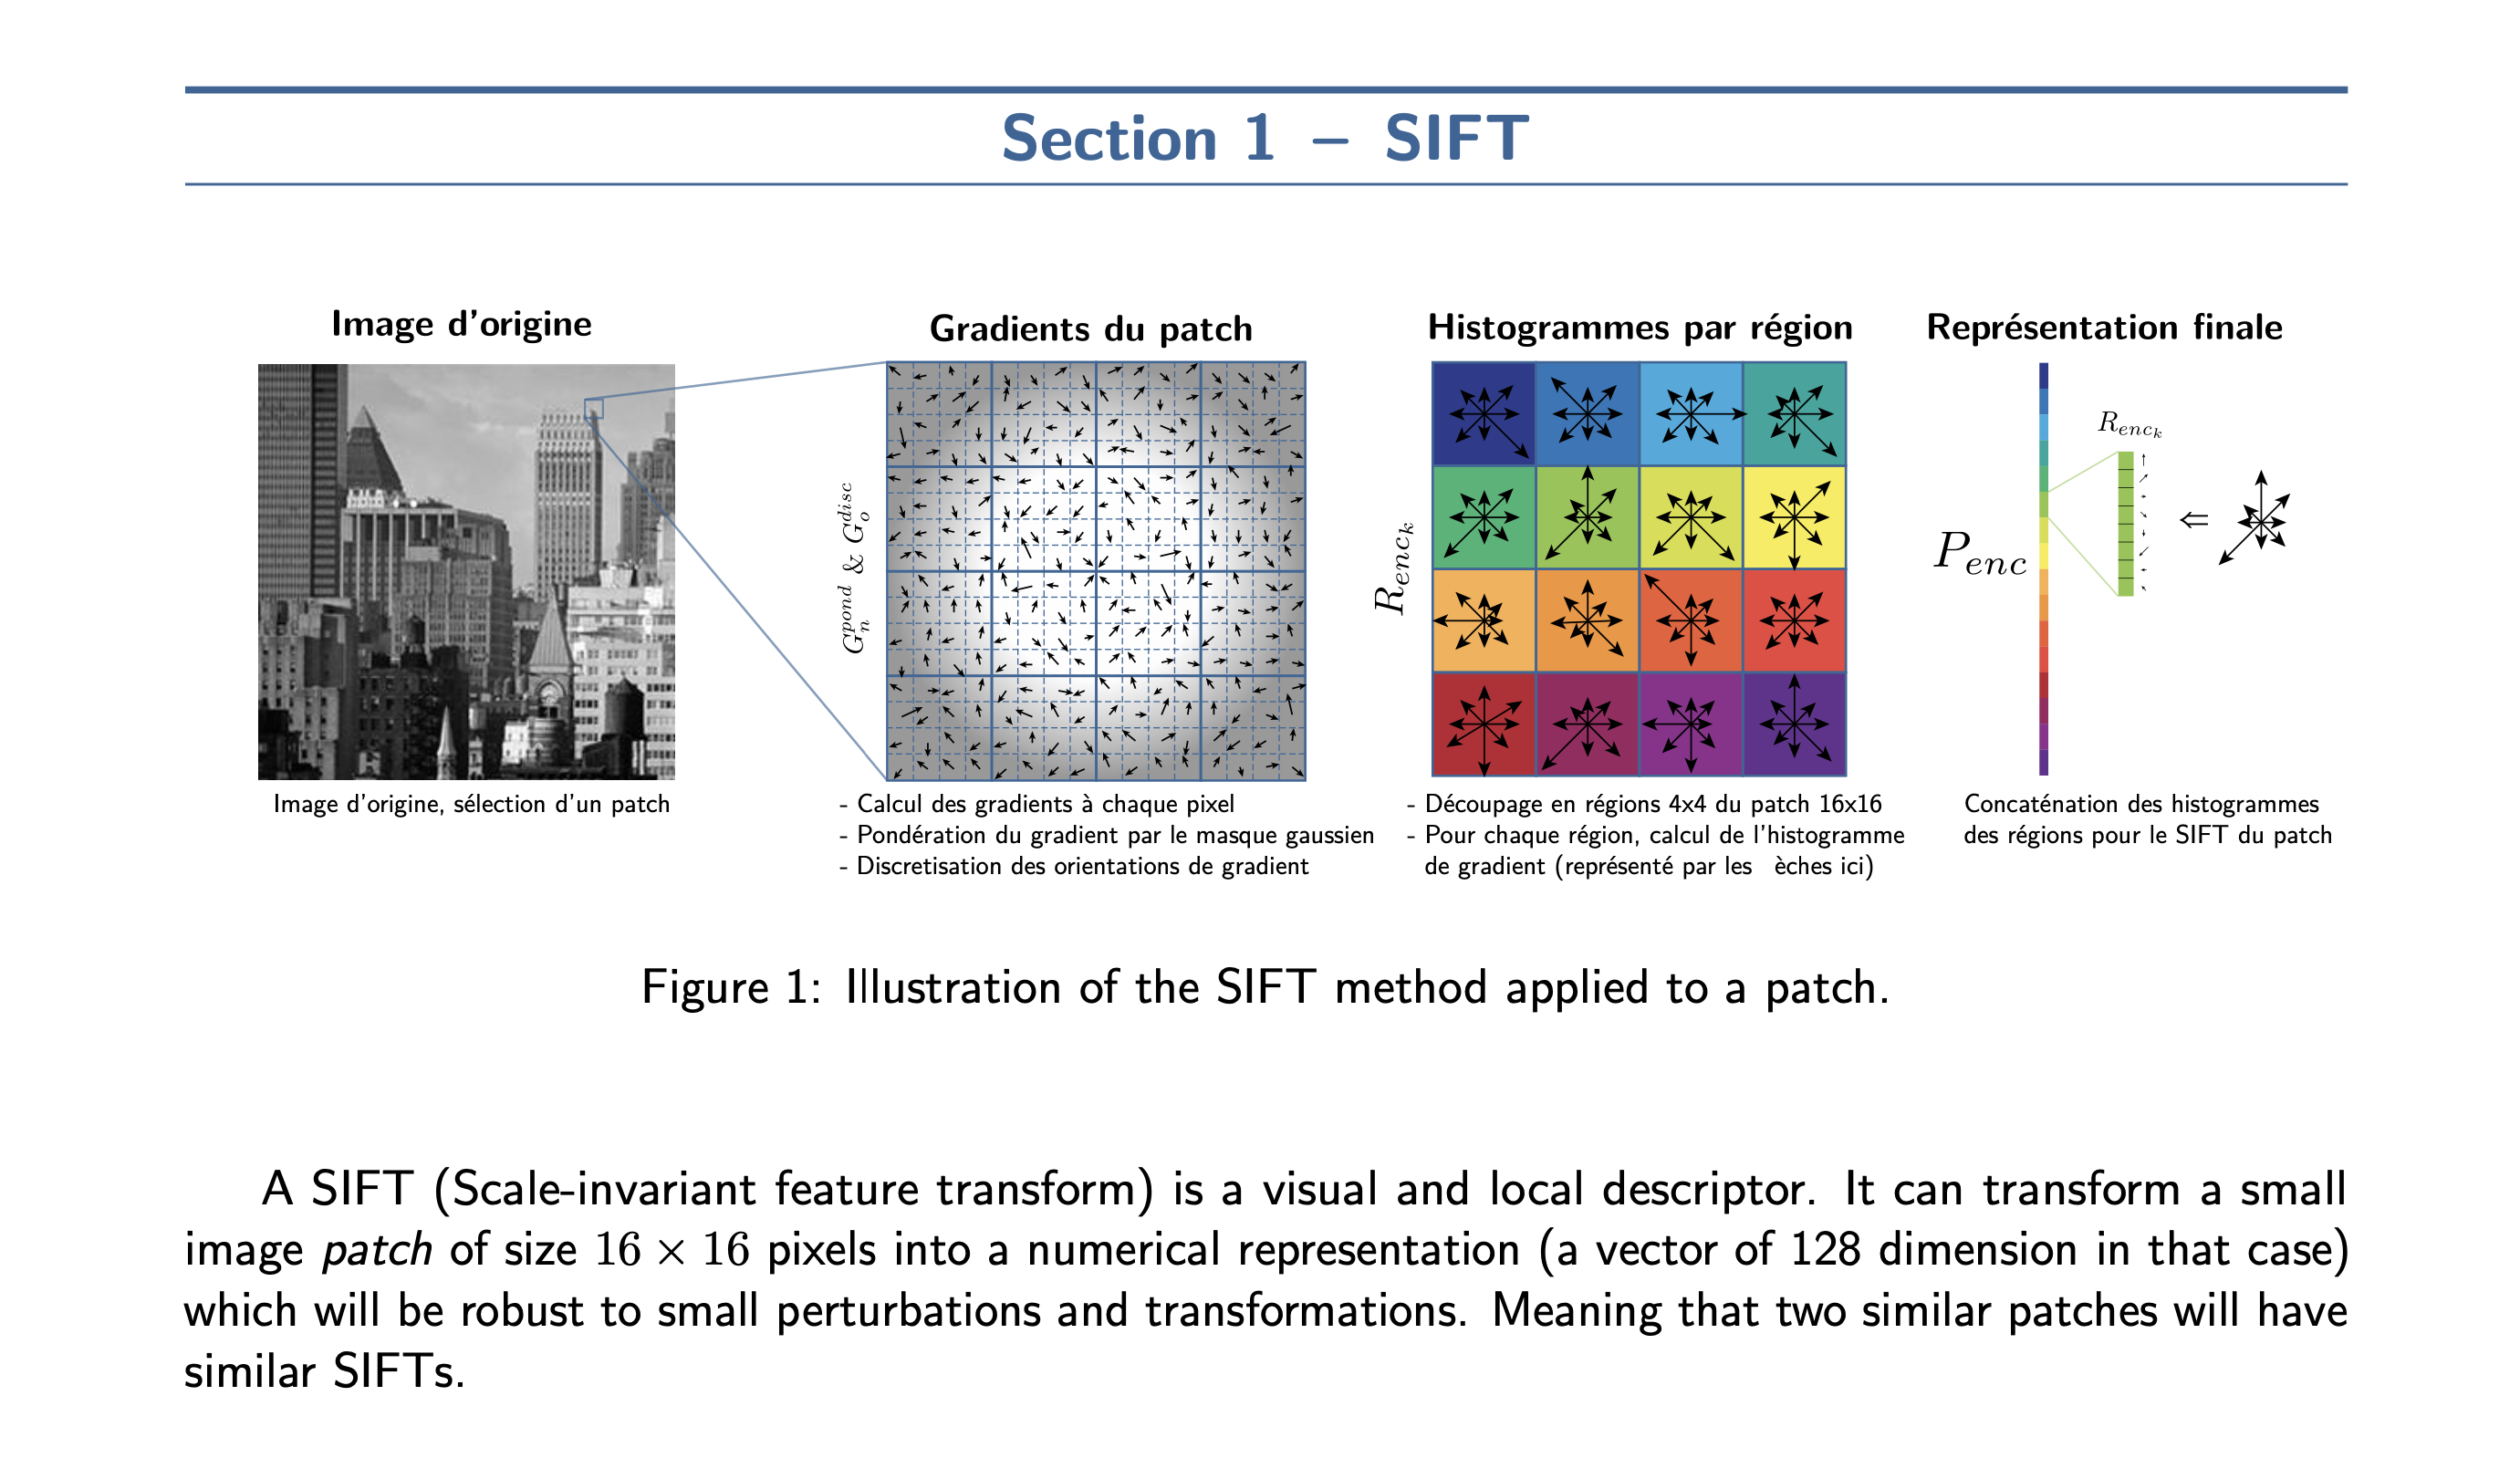

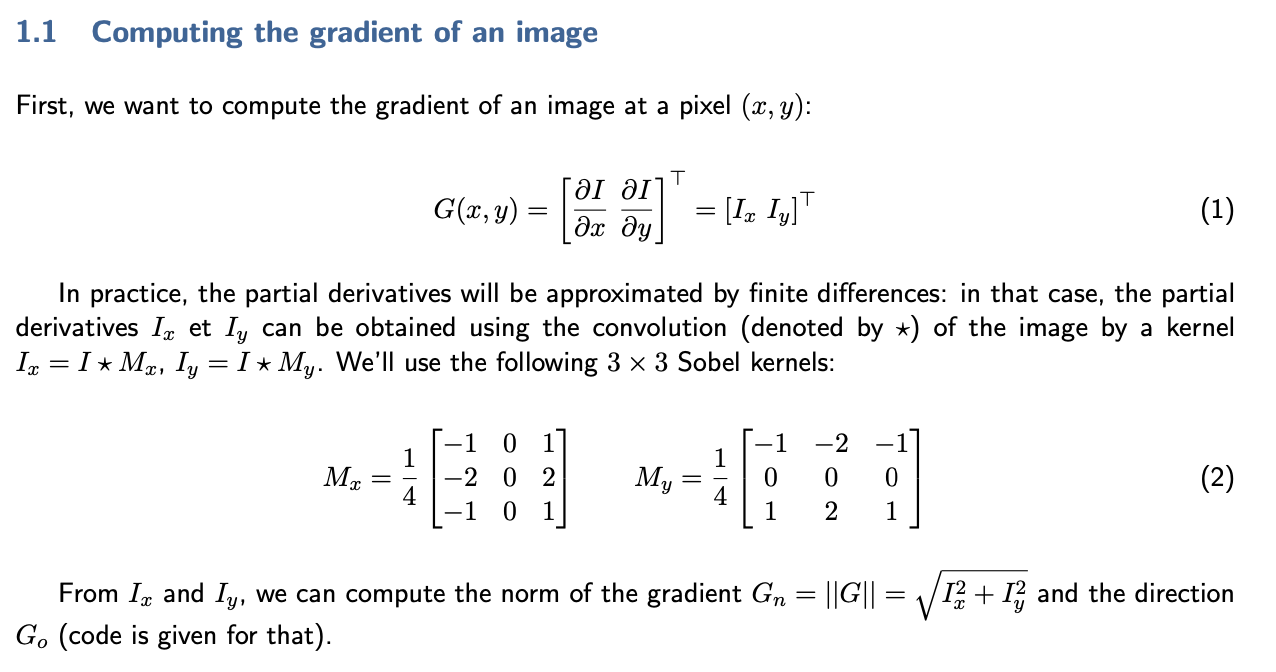

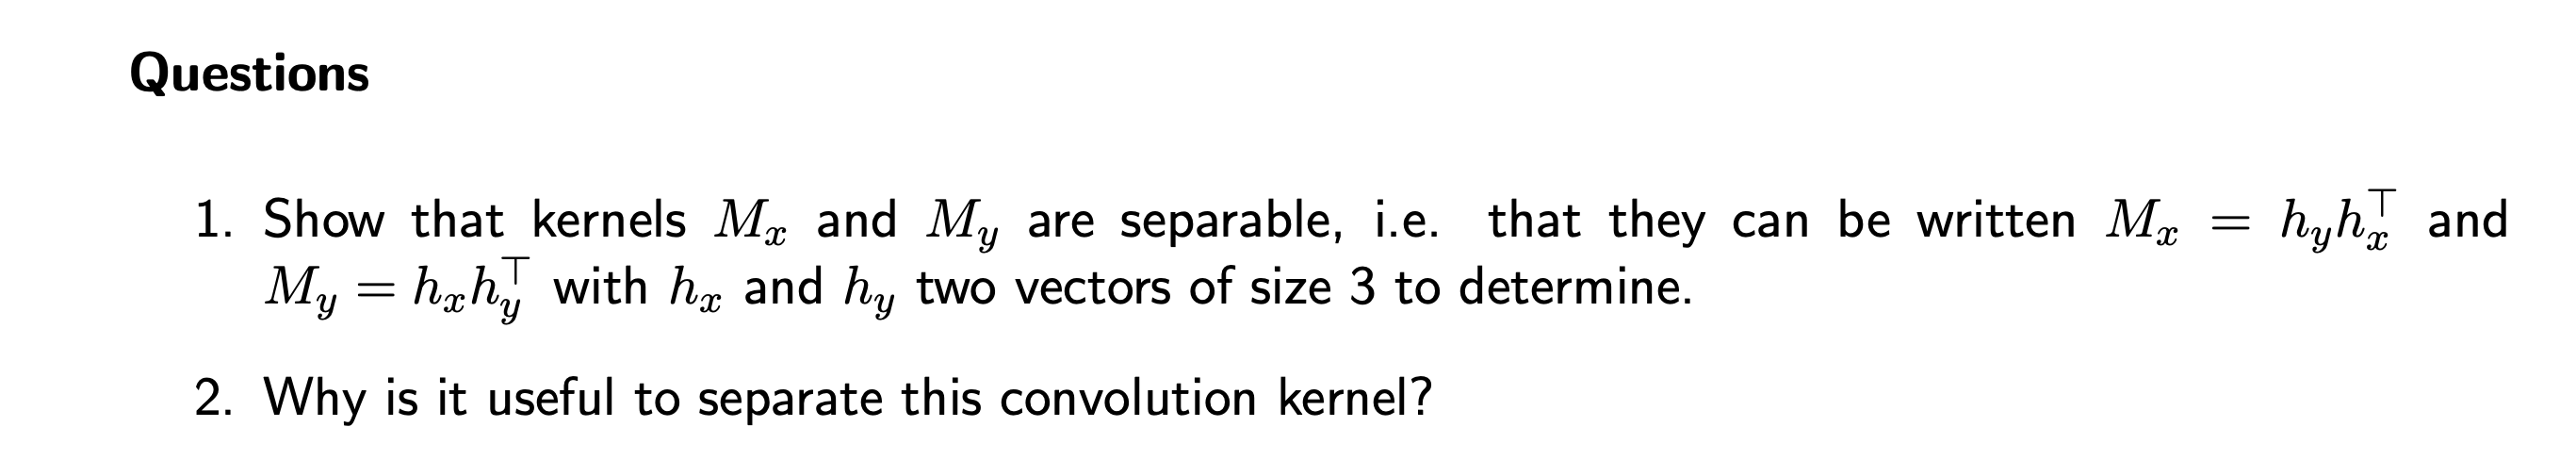

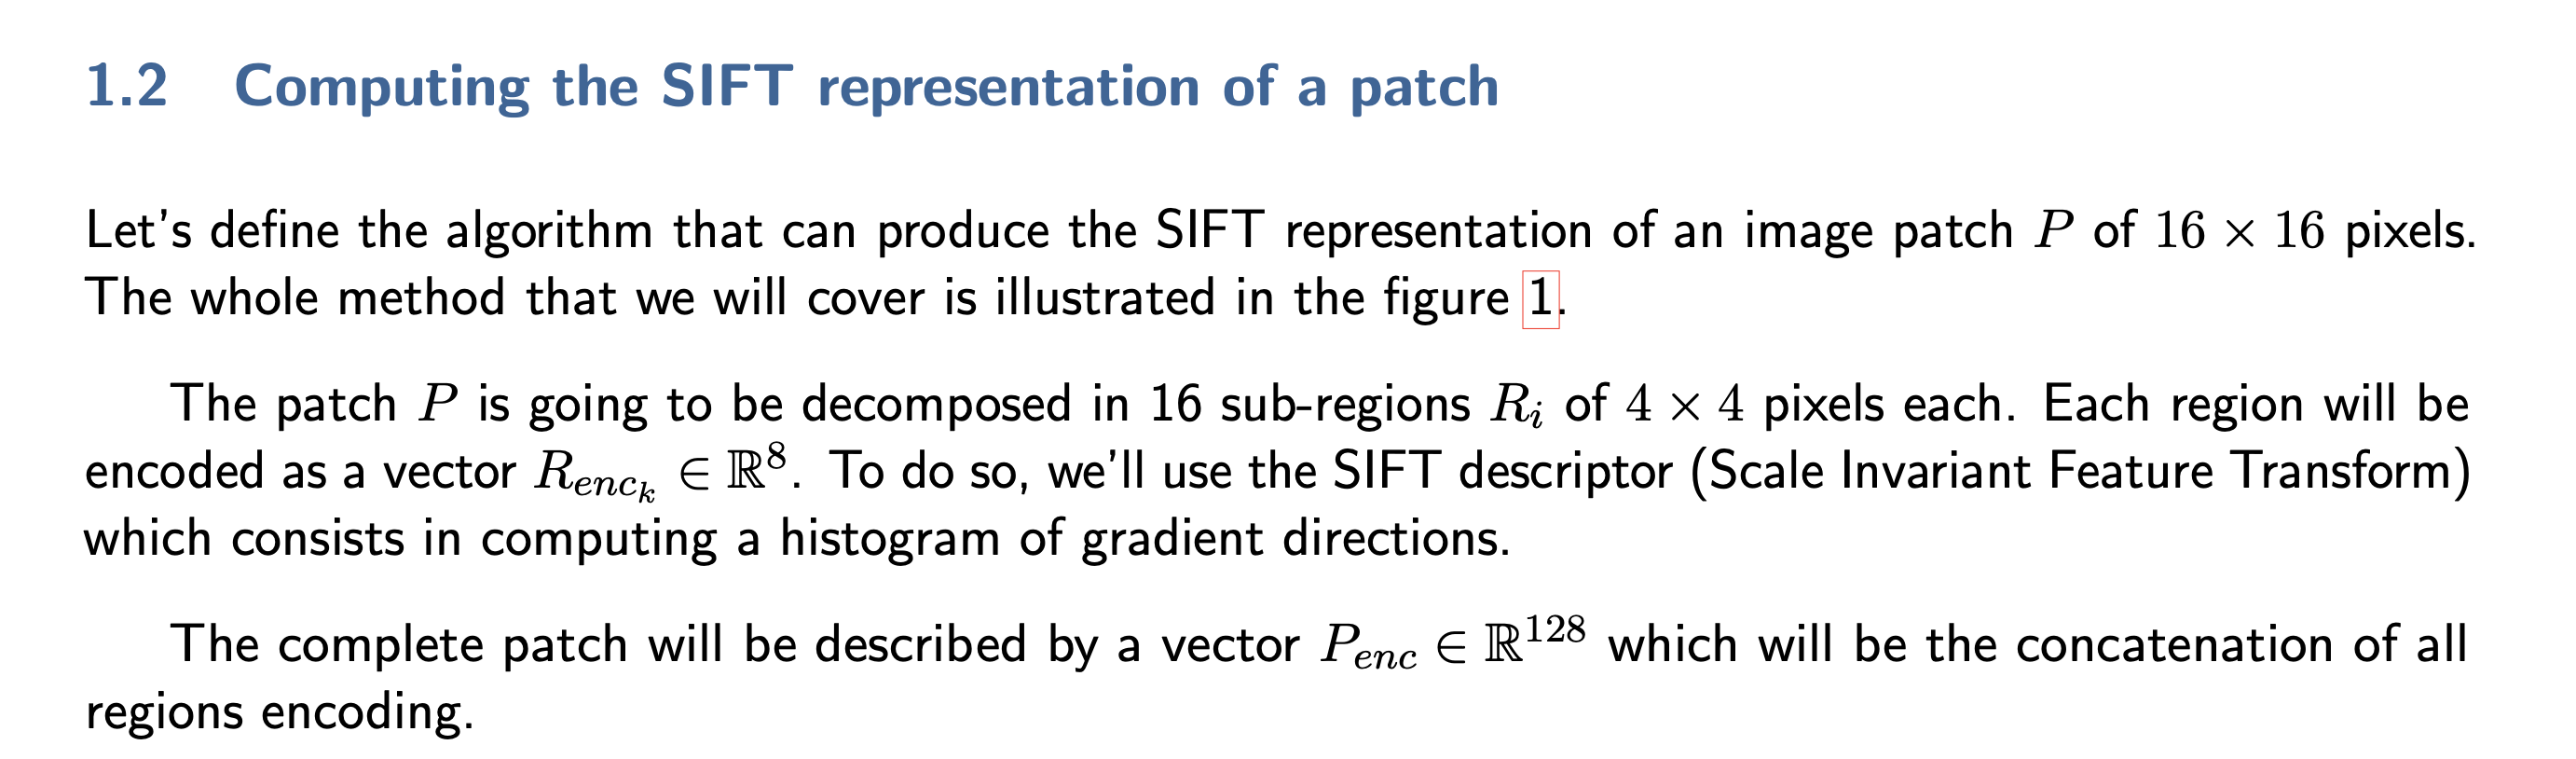

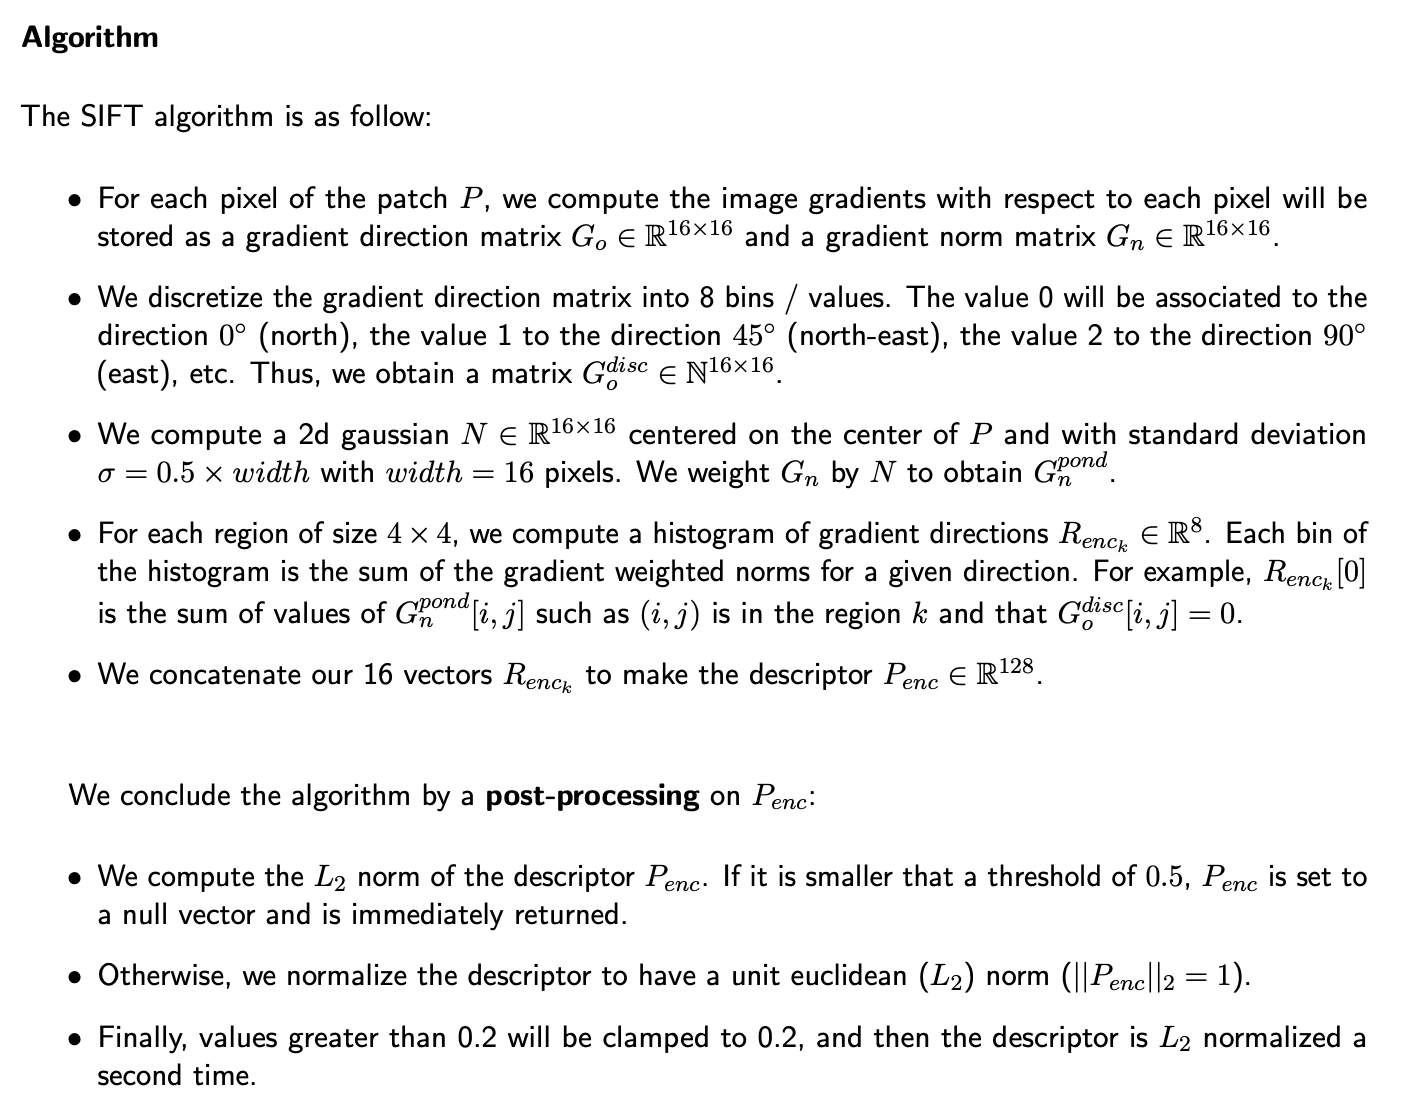

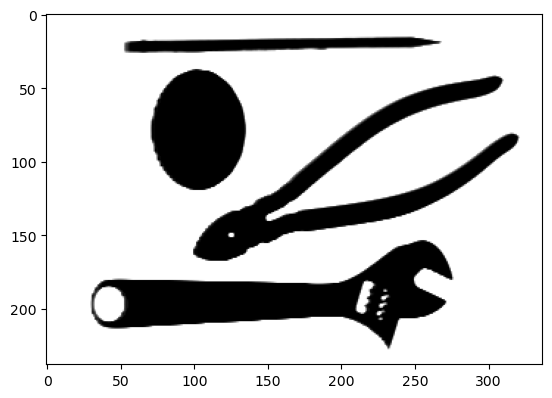

In [5]:
# example images
I = read_grayscale(join(data_path, 'tools.tiff'))
I2 = read_grayscale(join(data_path, 'Scene/CALsuburb/image_0205.jpg'))
plt.imshow(I, cmap='gray')

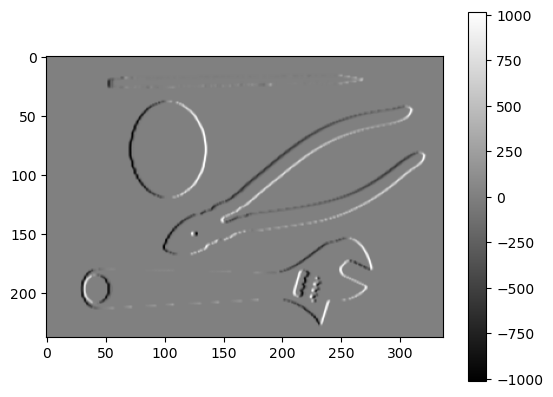

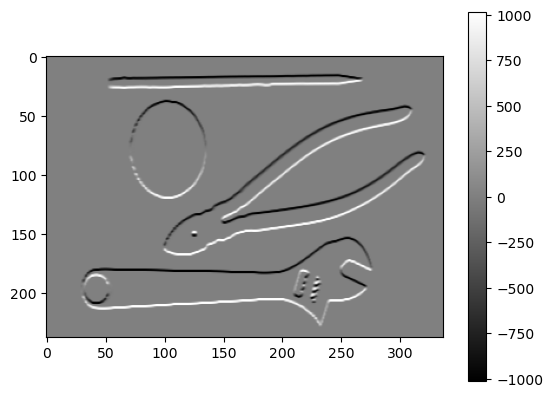

In [6]:
def compute_grad(I):
    hy = np.array([1, 2, 1])
    hx = np.array([-1, 0, 1])
    Ix = conv_separable(I, hx, hy)
    Iy = conv_separable(I, hy, hx)
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix, cmap="gray")
plt.colorbar()
plt.show()
plt.imshow(Iy, cmap="gray")
plt.colorbar()
plt.show()

In [7]:
I

array([[254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.],
       ...,
       [254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.]])

In [8]:
def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    Gn = np.sqrt(Ix**2 + Iy**2)
    Go = compute_grad_ori(Ix, Iy, Gn)
    return Gn, Go

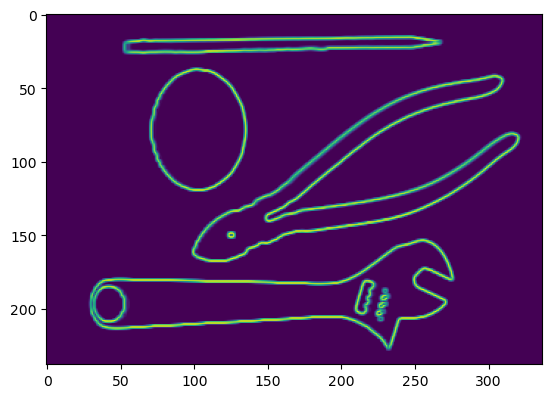

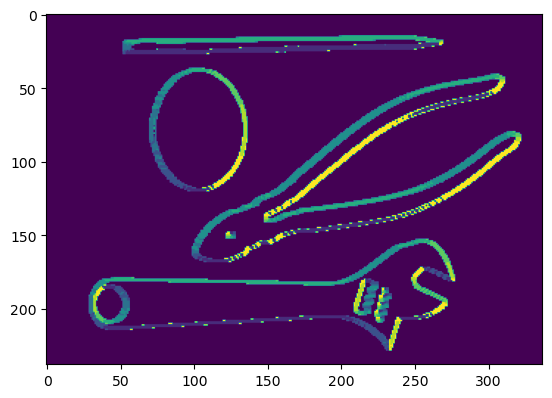

In [9]:
Gn, Go = compute_grad_mod_ori(I)
plt.imshow(Gn)#, cmap="gray")
plt.show()
plt.imshow(Go)#, cmap="gray")
plt.show()

In [10]:
Gn.shape

(238, 337)

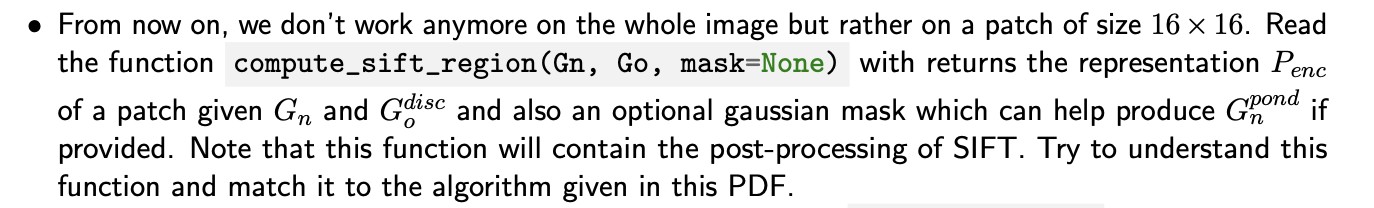

In [11]:
def compute_histogram(g_n, g_o):
    """
    g_n and g_o are 4x4 matrices that contain the norm, and the discretized orientation.
    Warning: g_o can contain -1, those values should be discarded.
    """
    hist = np.zeros((8))

    for j in range(4):
        for i in range(4):
            if g_o[i,j] != -1:
                hist[g_o[i,j]] += g_n[i,j]
    return hist


In [12]:
def compute_sift_region(Gn, Go, mask=None):
    t_min=.5
    t_max=.2
    with_l2 = True

    patch_size = 16
    sift = np.zeros((128))

    if mask is not None:
        Gn = Gn * mask

    idx = 0
    for k in range(0, patch_size, 4):
        for l in range(0, patch_size, 4):
            hist = compute_histogram(Gn[l:l+4,k:k+4], Go[l:l+4,k:k+4])
            sift[idx:idx+8] = hist
            idx += 8

    norm = np.linalg.norm(sift, ord=2)
    # min thresholding on norm
    if norm <= t_min:
        return np.zeros((128))
    # l2-normalization
    if with_l2:
        sift = sift / norm
    # max thresholding on values
    sift[sift >= t_max] = t_max
    # l2-normalization
    if with_l2:
        norm = np.linalg.norm(sift, ord=2)
        sift = sift / norm
    return sift

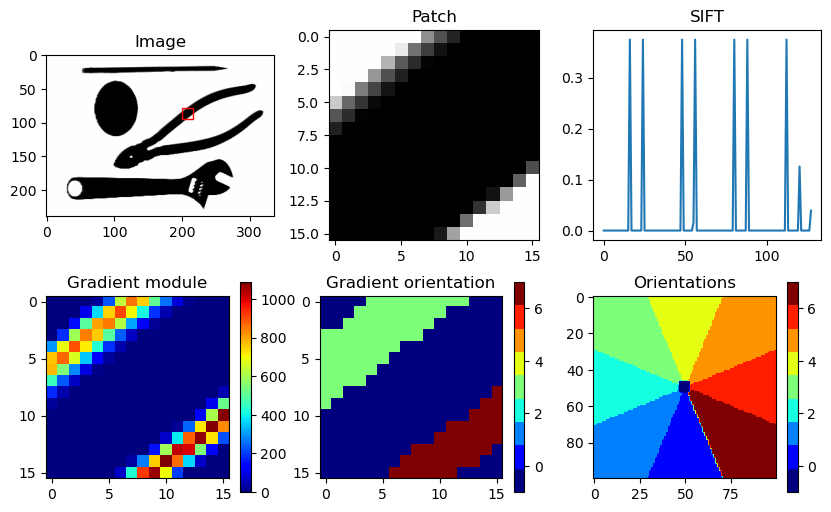

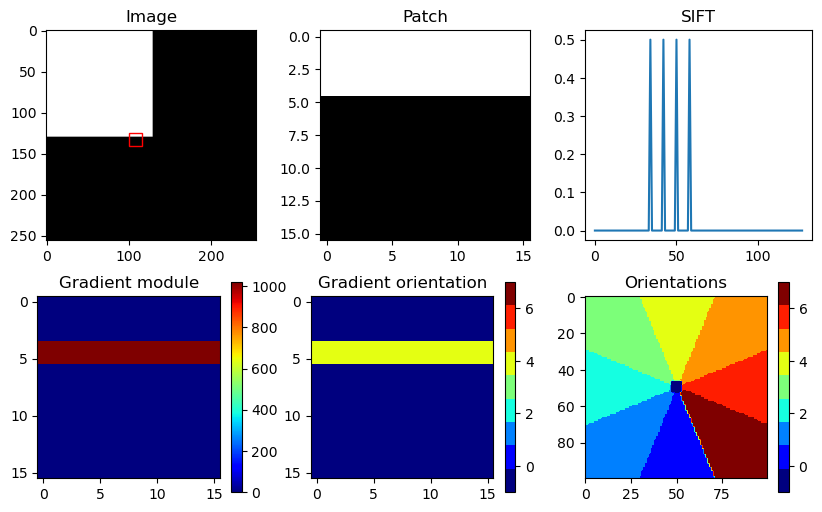

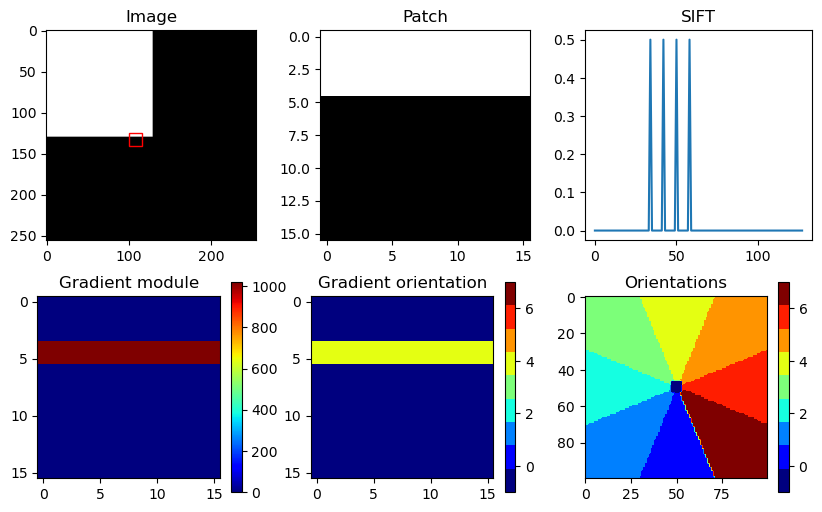

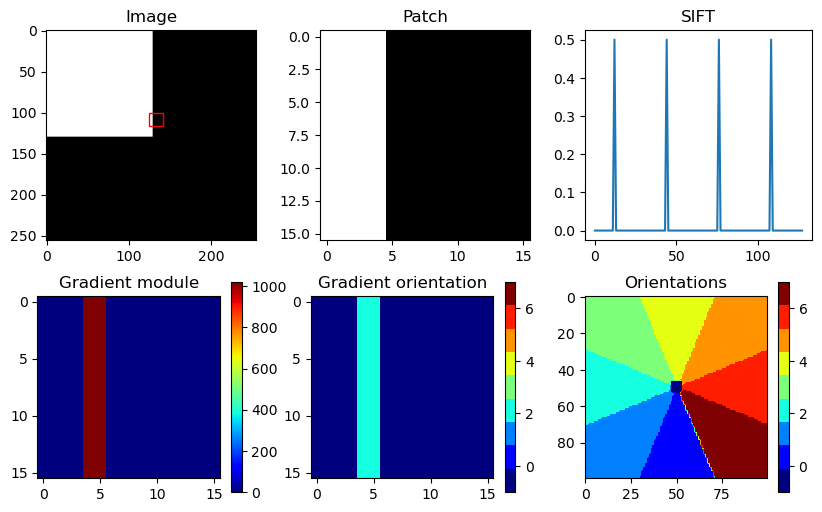

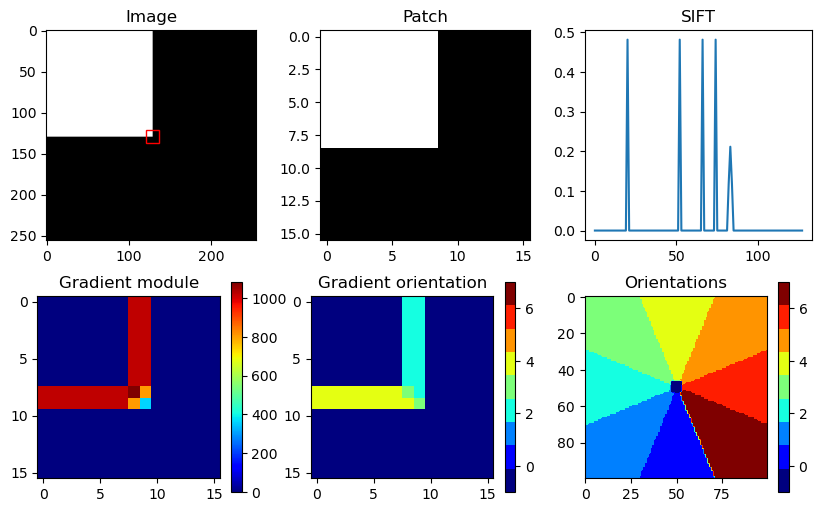

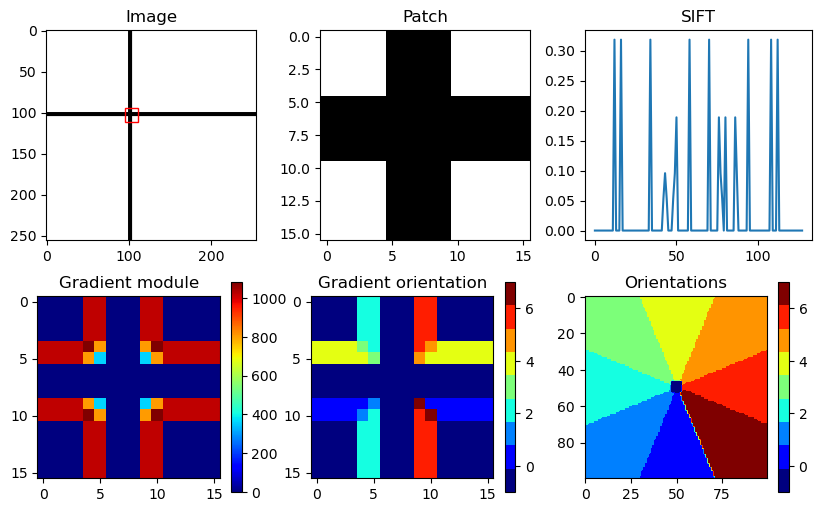

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3181317 , 0.        , 0.        ,
       0.        , 0.3181317 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3181317 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.05344409, 0.09560369,
       0.18864812, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.3181317 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.     

In [13]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

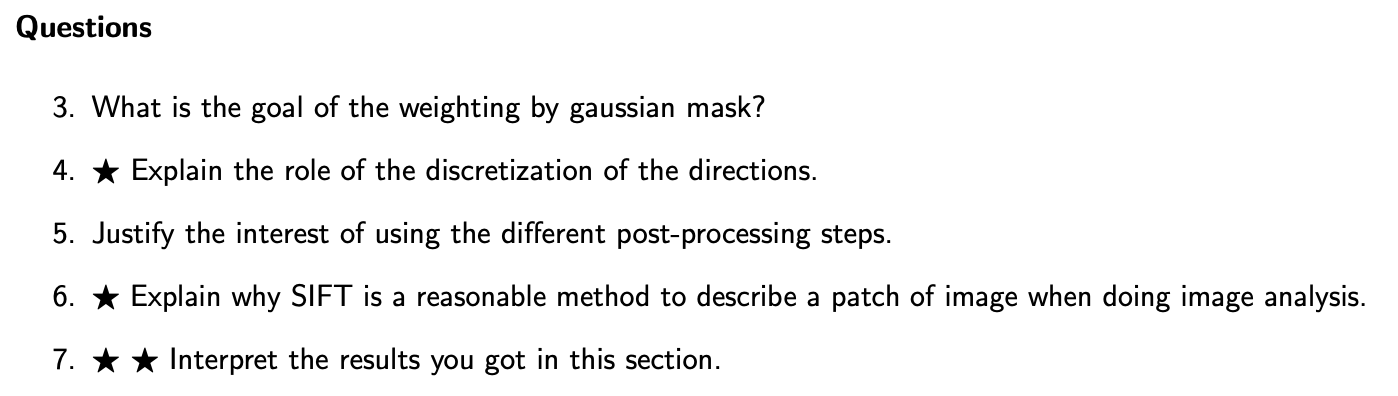

# Compute SIFT

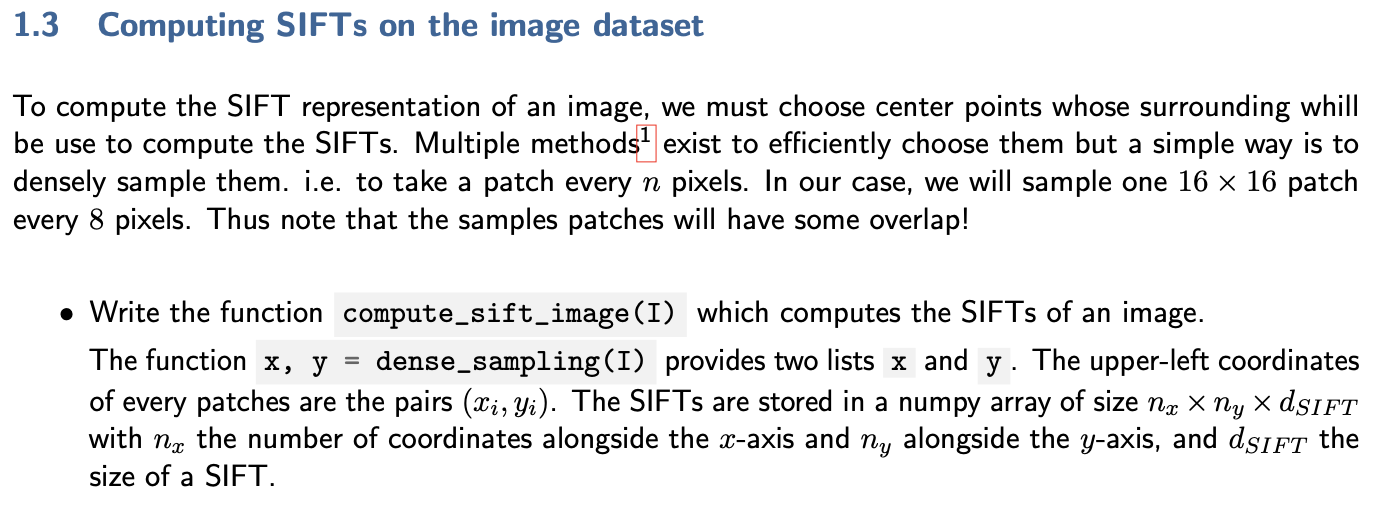

In [14]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    m = gaussian_mask()

    # Ici, effectuez les calculs sur l'image globale (norme, gradients)
    Gn, Go = compute_grad_mod_ori(im)

    k = 16
    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):

            g_m_r = Gn[xi:xi+k, yj:yj+k]
            g_o_r = Go[xi:xi+k, yj:yj+k]
            sifts[i,j] = compute_sift_region(g_m_r, g_o_r, mask=m)

    return sifts



The computation may last several minutes.

In [15]:
max_images_per_class = 10  # You can change this to None to compute the whole dataset (takes quite some time)

save_path = "data/"
dir_sc = os.path.join(data_path, 'Scene')
dir_sift = os.path.join(save_path, 'sift')
inames, ilabls, cnames = load_dataset(dir_sc, images_per_class=max_images_per_class)
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs
1/150
2/150
3/150
4/150
5/150
6/150
7/150
8/150
9/150
10/150
11/150
12/150
13/150
14/150
15/150
16/150
17/150
18/150
19/150
20/150
21/150
22/150
23/150
24/150
25/150
26/150
27/150
28/150
29/150
30/150
31/150
32/150
33/150
34/150
35/150
36/150
37/150
38/150
39/150
40/150
41/150
42/150
43/150
44/150
45/150
46/150
47/150
48/150
49/150
50/150
51/150
52/150
53/150
54/150
55/150
56/150
57/150
58/150
59/150
60/150
61/150
62/150
63/150
64/150
65/150
66/150
67/150
68/150
69/150
70/150
71/150
72/150
73/150
74/150
75/150
76/150
77/150
78/150
79/150
80/150
81/150
82/150
83/150
84/150
85/150
86/150
87/150
88/150
89/150
90/150
91/150
92/150
93/150
94/150
95/150
96/150
97/150
98/150
99/150
100/150
101/150
102/150
103/150
104/150
105/150
106/150
107/150
108/150
109/150
110/150
111/150
112/150
113/150
114/150
115/150
116/150
117/150
118/150
119/150
120/150
121/150
122/150
123/150
124/150
125/150
126/150
127/150
128/150
129/150
130/150
131/150
132/150
133/150
134/150
135/150
1

In [16]:
sifts_list_by_image[0].shape

(28, 42, 128)

# Part II: Visual Dictionary

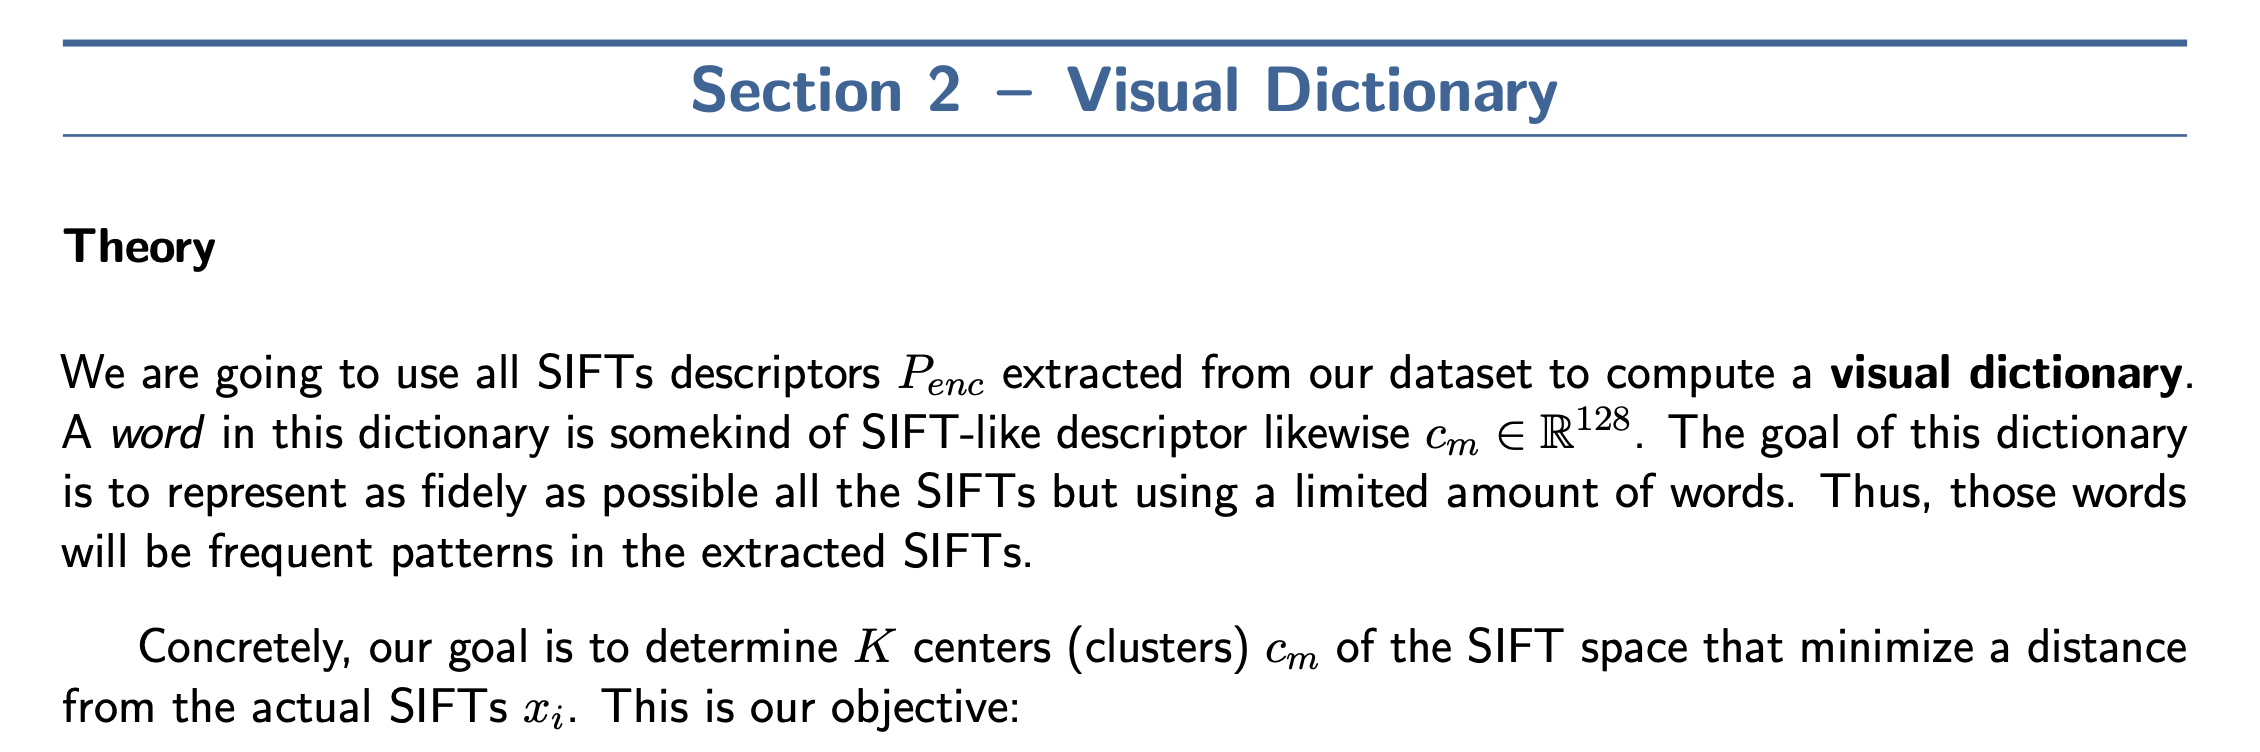

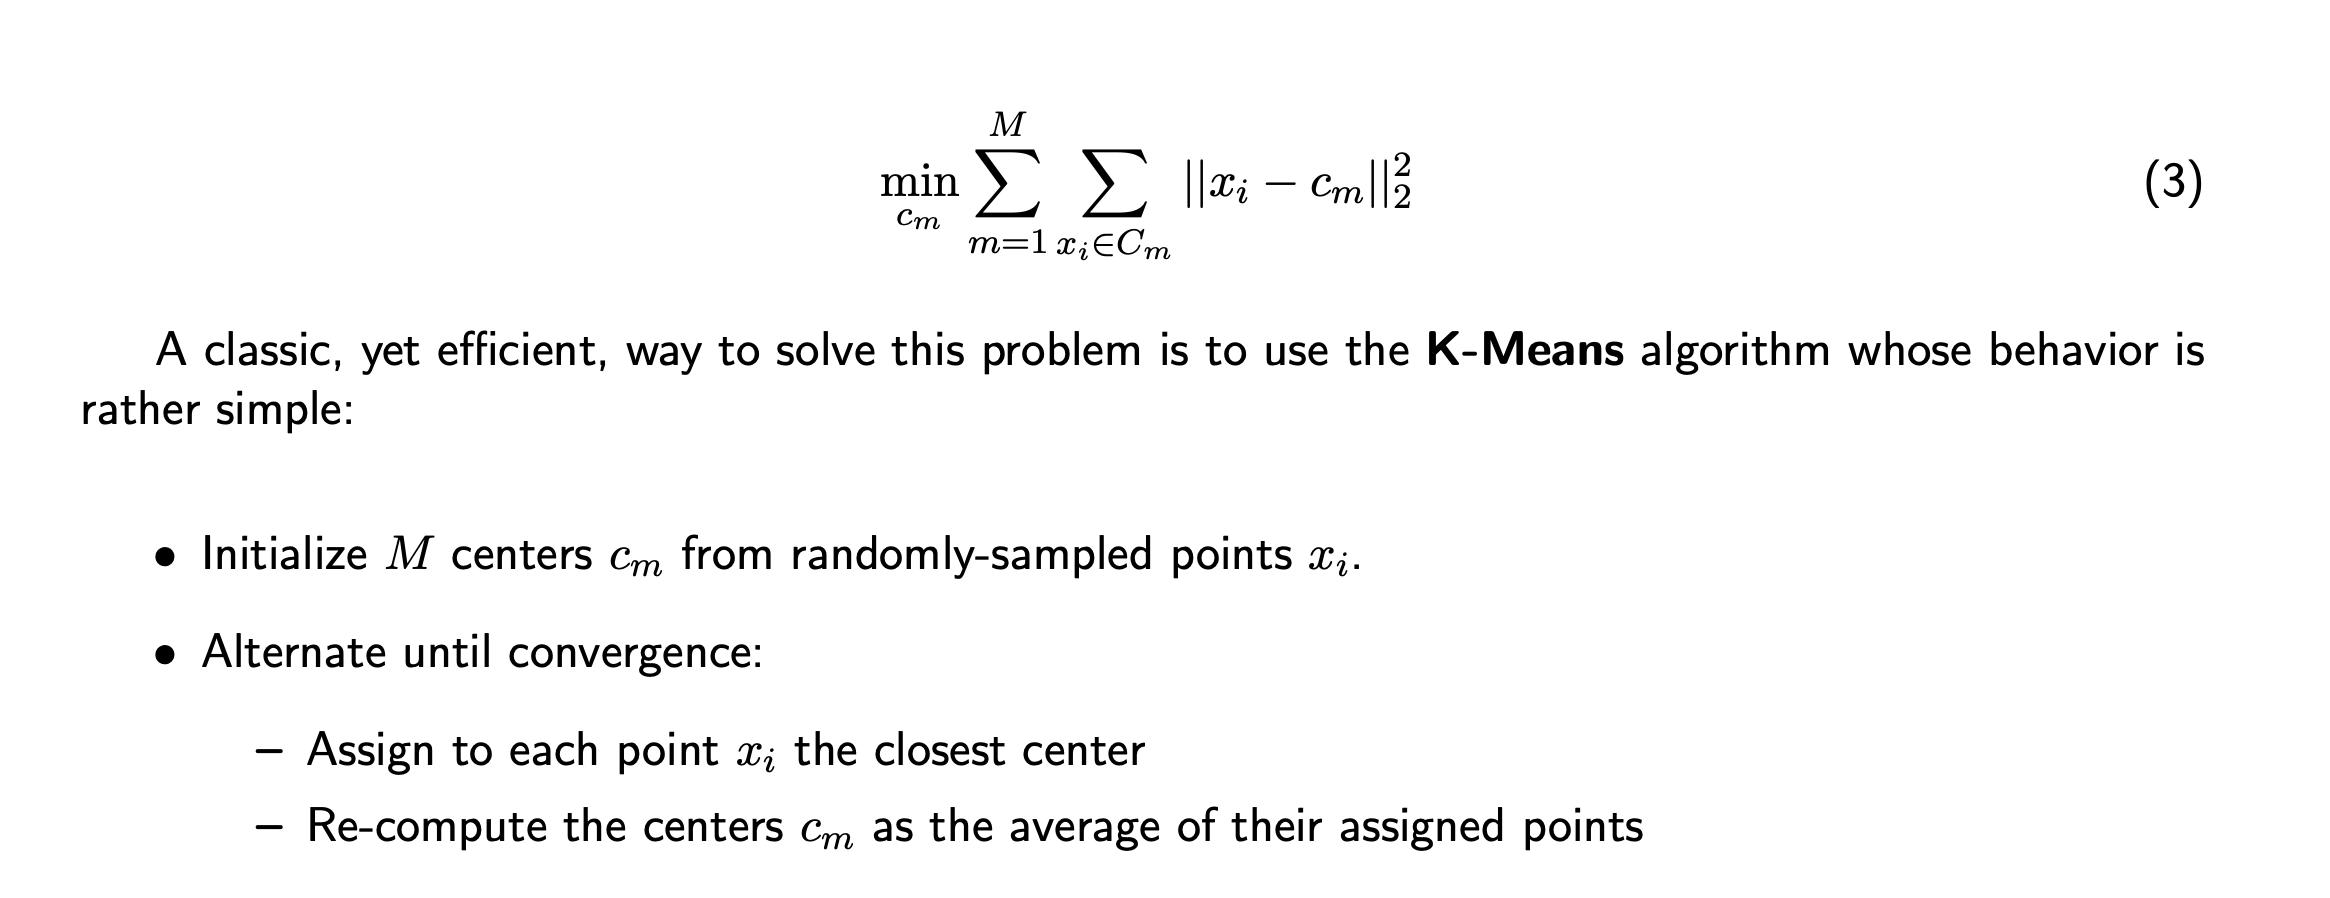

In [17]:
from sklearn.cluster import KMeans

path_vdict = os.path.join(save_path, 'kmeans', 'vdict.npy')
os.makedirs(os.path.join(save_path, 'kmeans'), exist_ok=True)

In [18]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    print("shape sifts:", sift.shape)

    # Compute kmeans on `sift`, get cluster centers, add zeros vector, and return visual dict

    kmeans = KMeans(
        n_clusters=n_clusters,
        verbose=verbose,
        n_init=n_init,
        max_iter=10,
       # n_jobs=3
    )
    kmeans.fit(sift)
    vdict = kmeans.cluster_centers_
    vdict = np.append(vdict, np.zeros((1, dim_sift)), axis=0)
    return vdict


In [19]:
# Run the visual dict computation (saved the first time)
# from tools import compute_vdict

#vdict = compute_visual_dict(sifts_list_by_image)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict
Computing or loading SIFTs
1/150
2/150
3/150
4/150
5/150
6/150
7/150
8/150
9/150
10/150
11/150
12/150
13/150
14/150
15/150
16/150
17/150
18/150
19/150
20/150
21/150
22/150
23/150
24/150
25/150
26/150
27/150
28/150
29/150
30/150
31/150
32/150
33/150
34/150
35/150
36/150
37/150
38/150
39/150
40/150
41/150
42/150
43/150
44/150
45/150
46/150
47/150
48/150
49/150
50/150
51/150
52/150
53/150
54/150
55/150
56/150
57/150
58/150
59/150
60/150
61/150
62/150
63/150
64/150
65/150
66/150
67/150
68/150
69/150
70/150
71/150
72/150
73/150
74/150
75/150
76/150
77/150
78/150
79/150
80/150
81/150
82/150
83/150
84/150
85/150
86/150
87/150
88/150
89/150
90/150
91/150
92/150
93/150
94/150
95/150
96/150
97/150
98/150
99/150
100/150
101/150
102/150
103/150
104/150
105/150
106/150
107/150
108/150
109/150
110/150
111/150
112/150
113/150
114/150
115/150
116/150
117/150
118/150
119/150
120/150
121/150
122/150
123/150
124/150
125/150
126/150
127/150
128/150
129/150
130/150
131/150


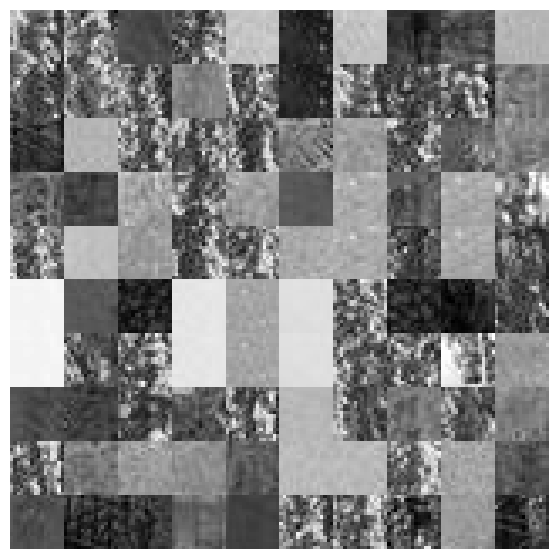

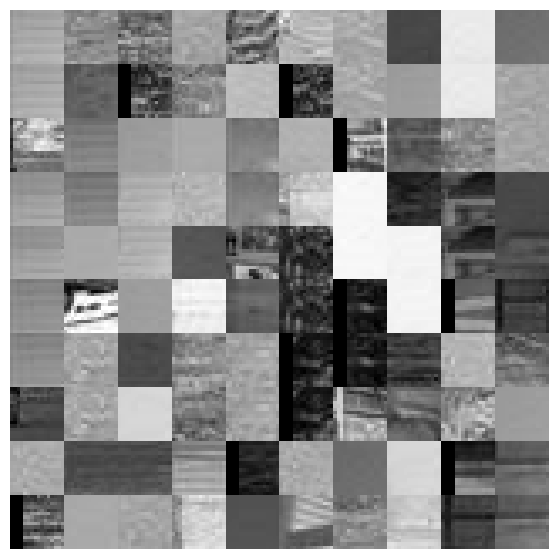

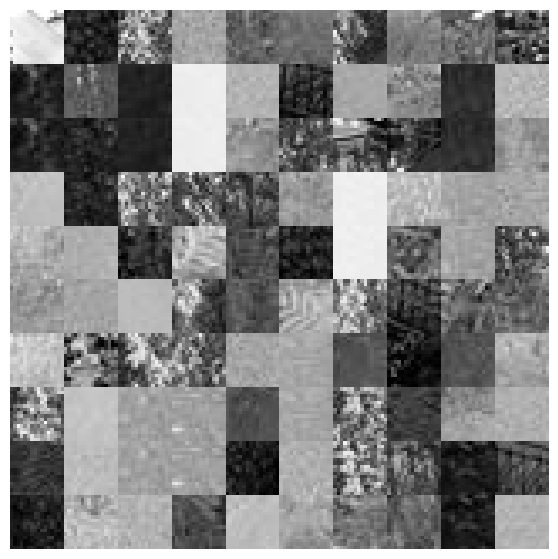

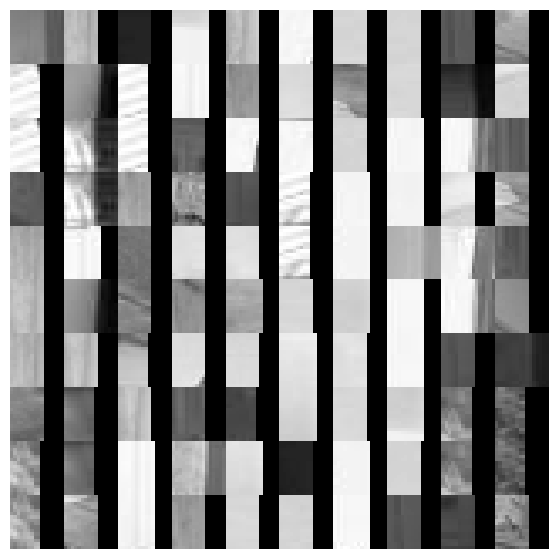

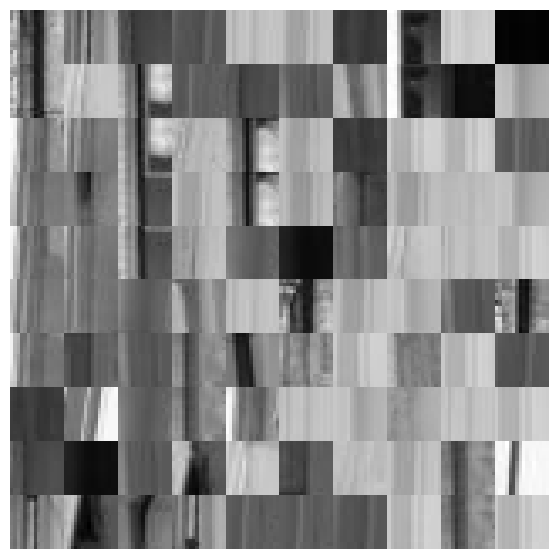

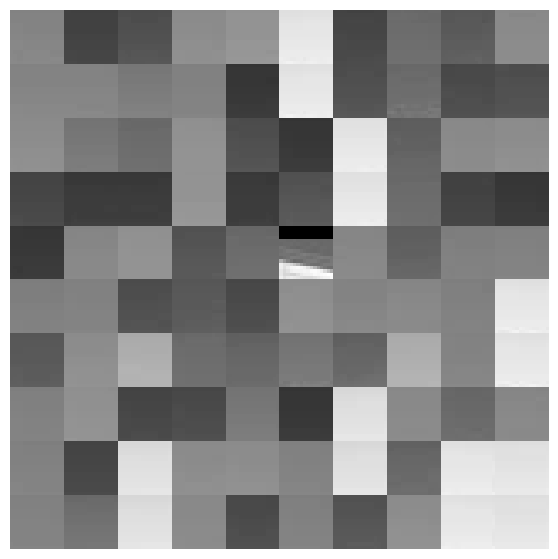

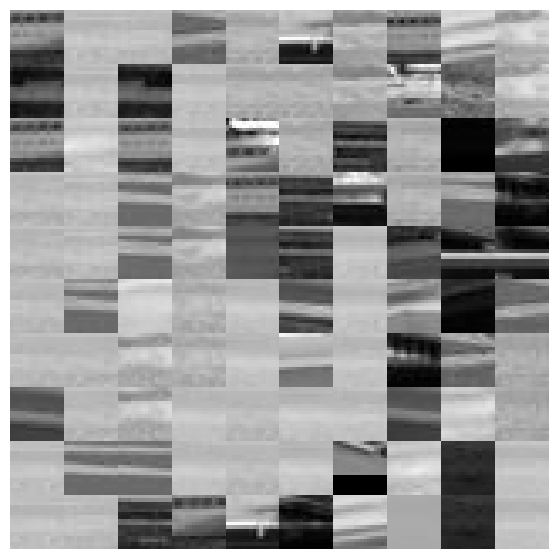

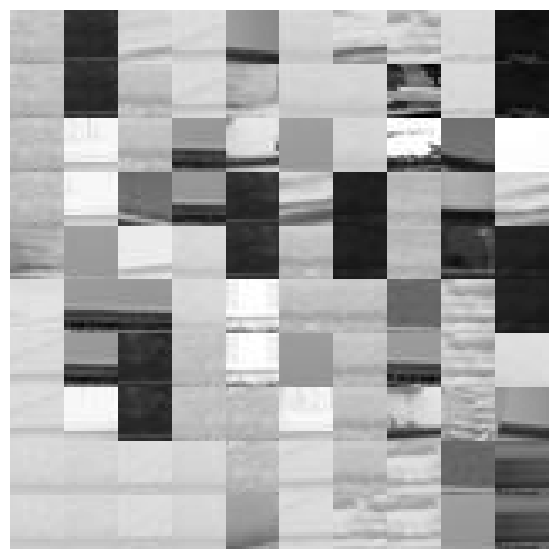

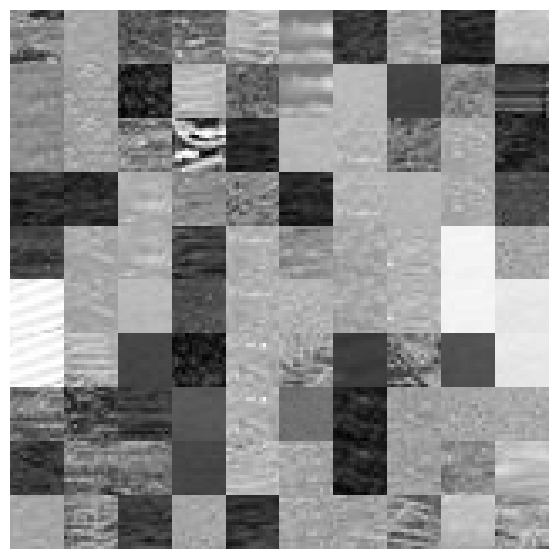

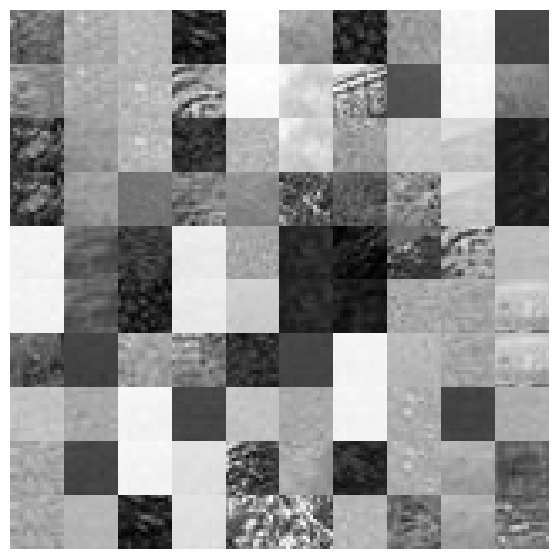

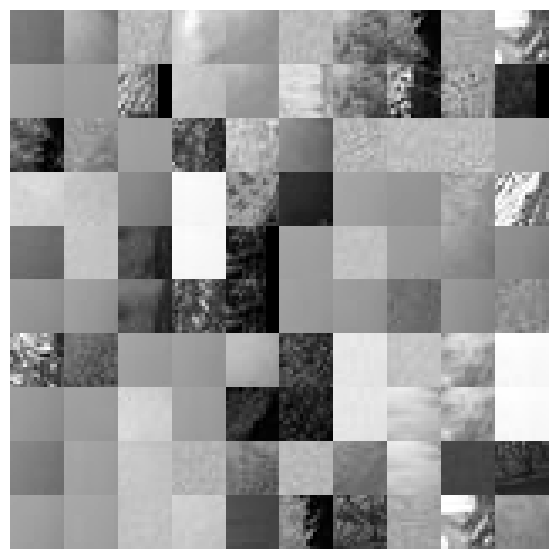

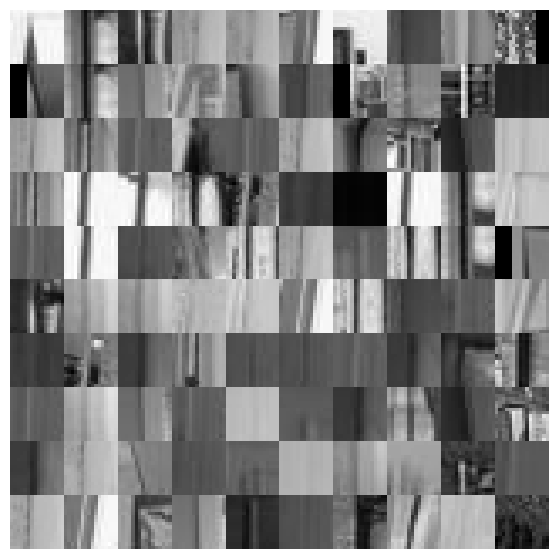

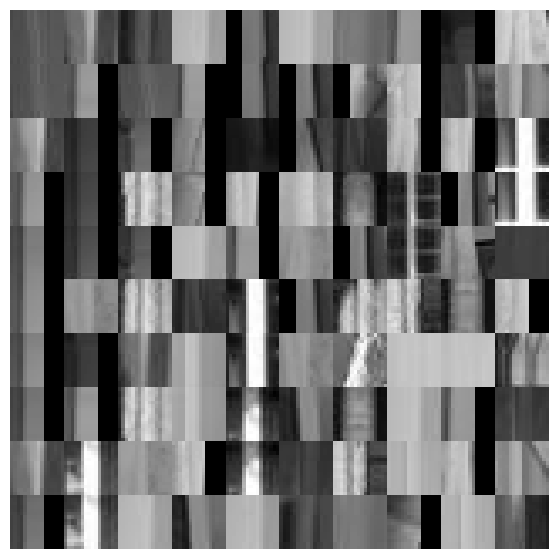

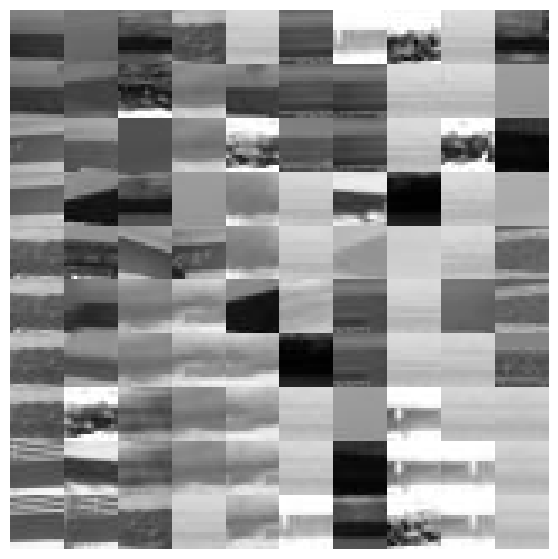

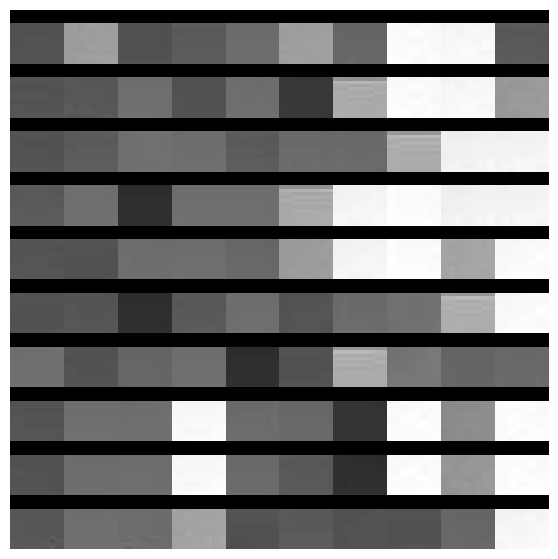

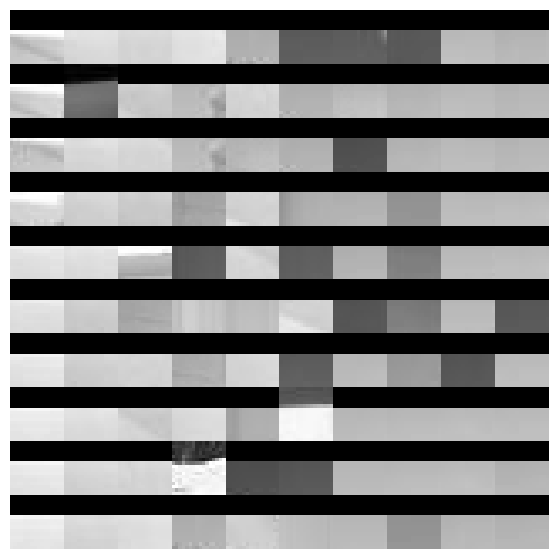

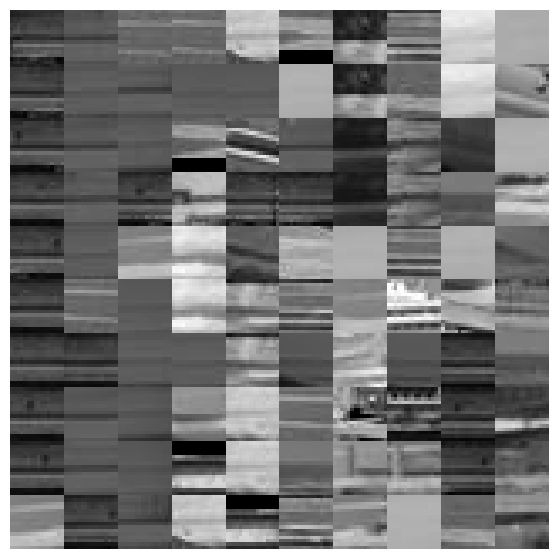

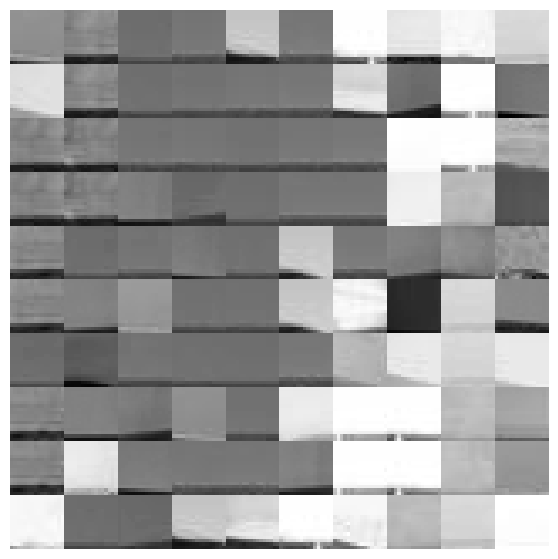

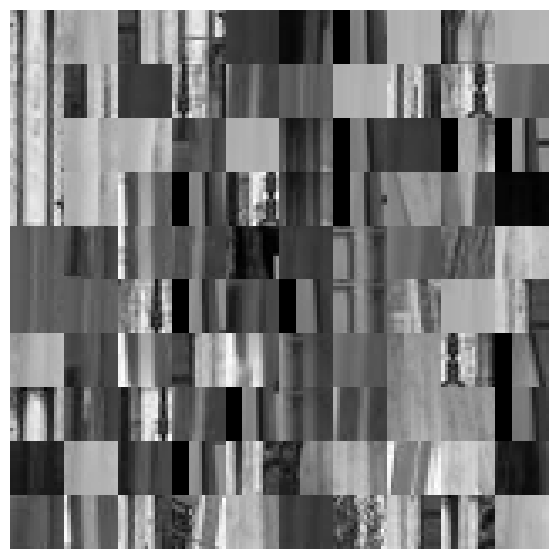

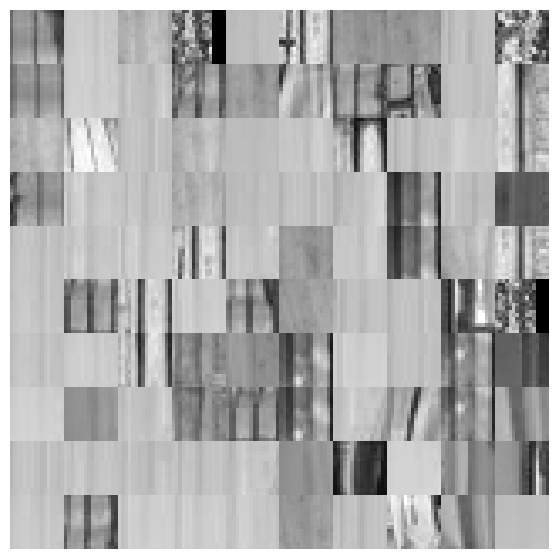

In [20]:
# Study of the dict

# choose random images
indexes = np.random.randint(0, len(inames), 30)
sifts = [sifts_list_by_image[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]

regions, sifts = get_regions_and_sifts(dir_sc, chosen_inames, sifts) # Compute SIFT and regions from 30 random images
# display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

centers = list(range(20))
for center in centers:
  center_vect = vdict[center]
  dist = ((sifts - center_vect)**2).sum(axis=1)
  # get best 100
  top100 = dist.argsort()[:100]
  top100_regions = regions[top100]
  display_images(top100_regions) # Show 100 random regions

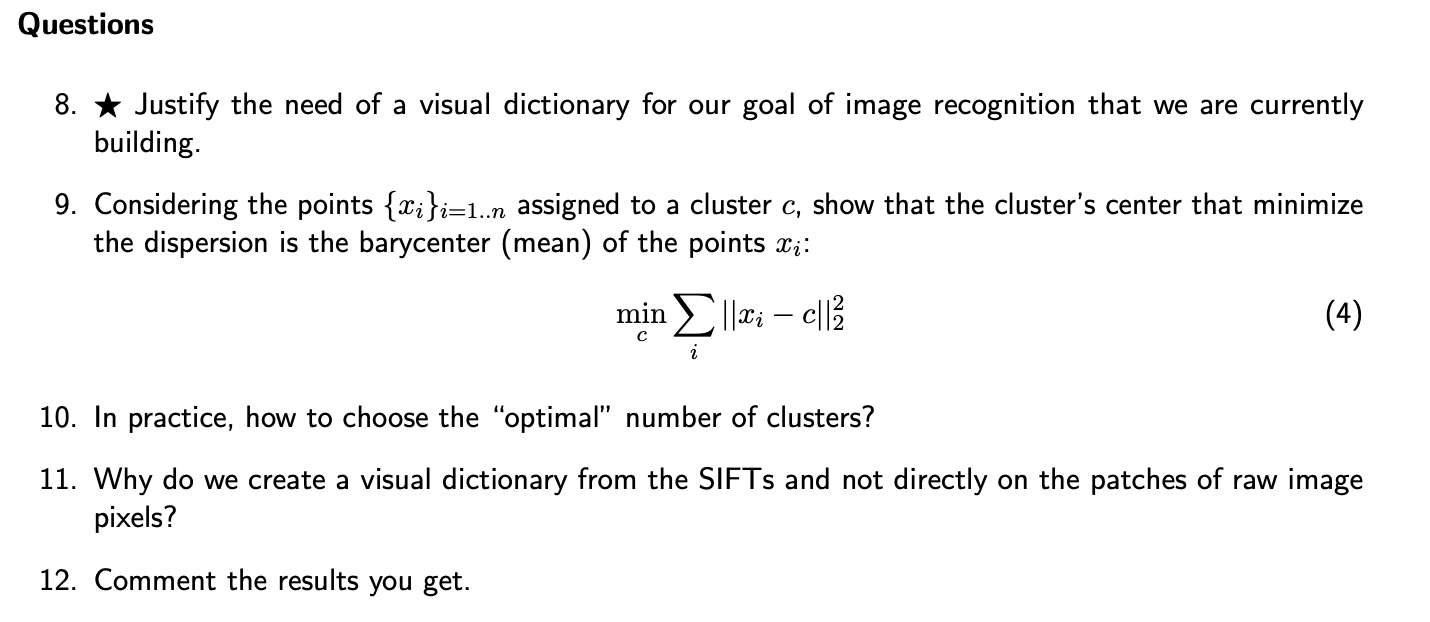

# Part III: BoW

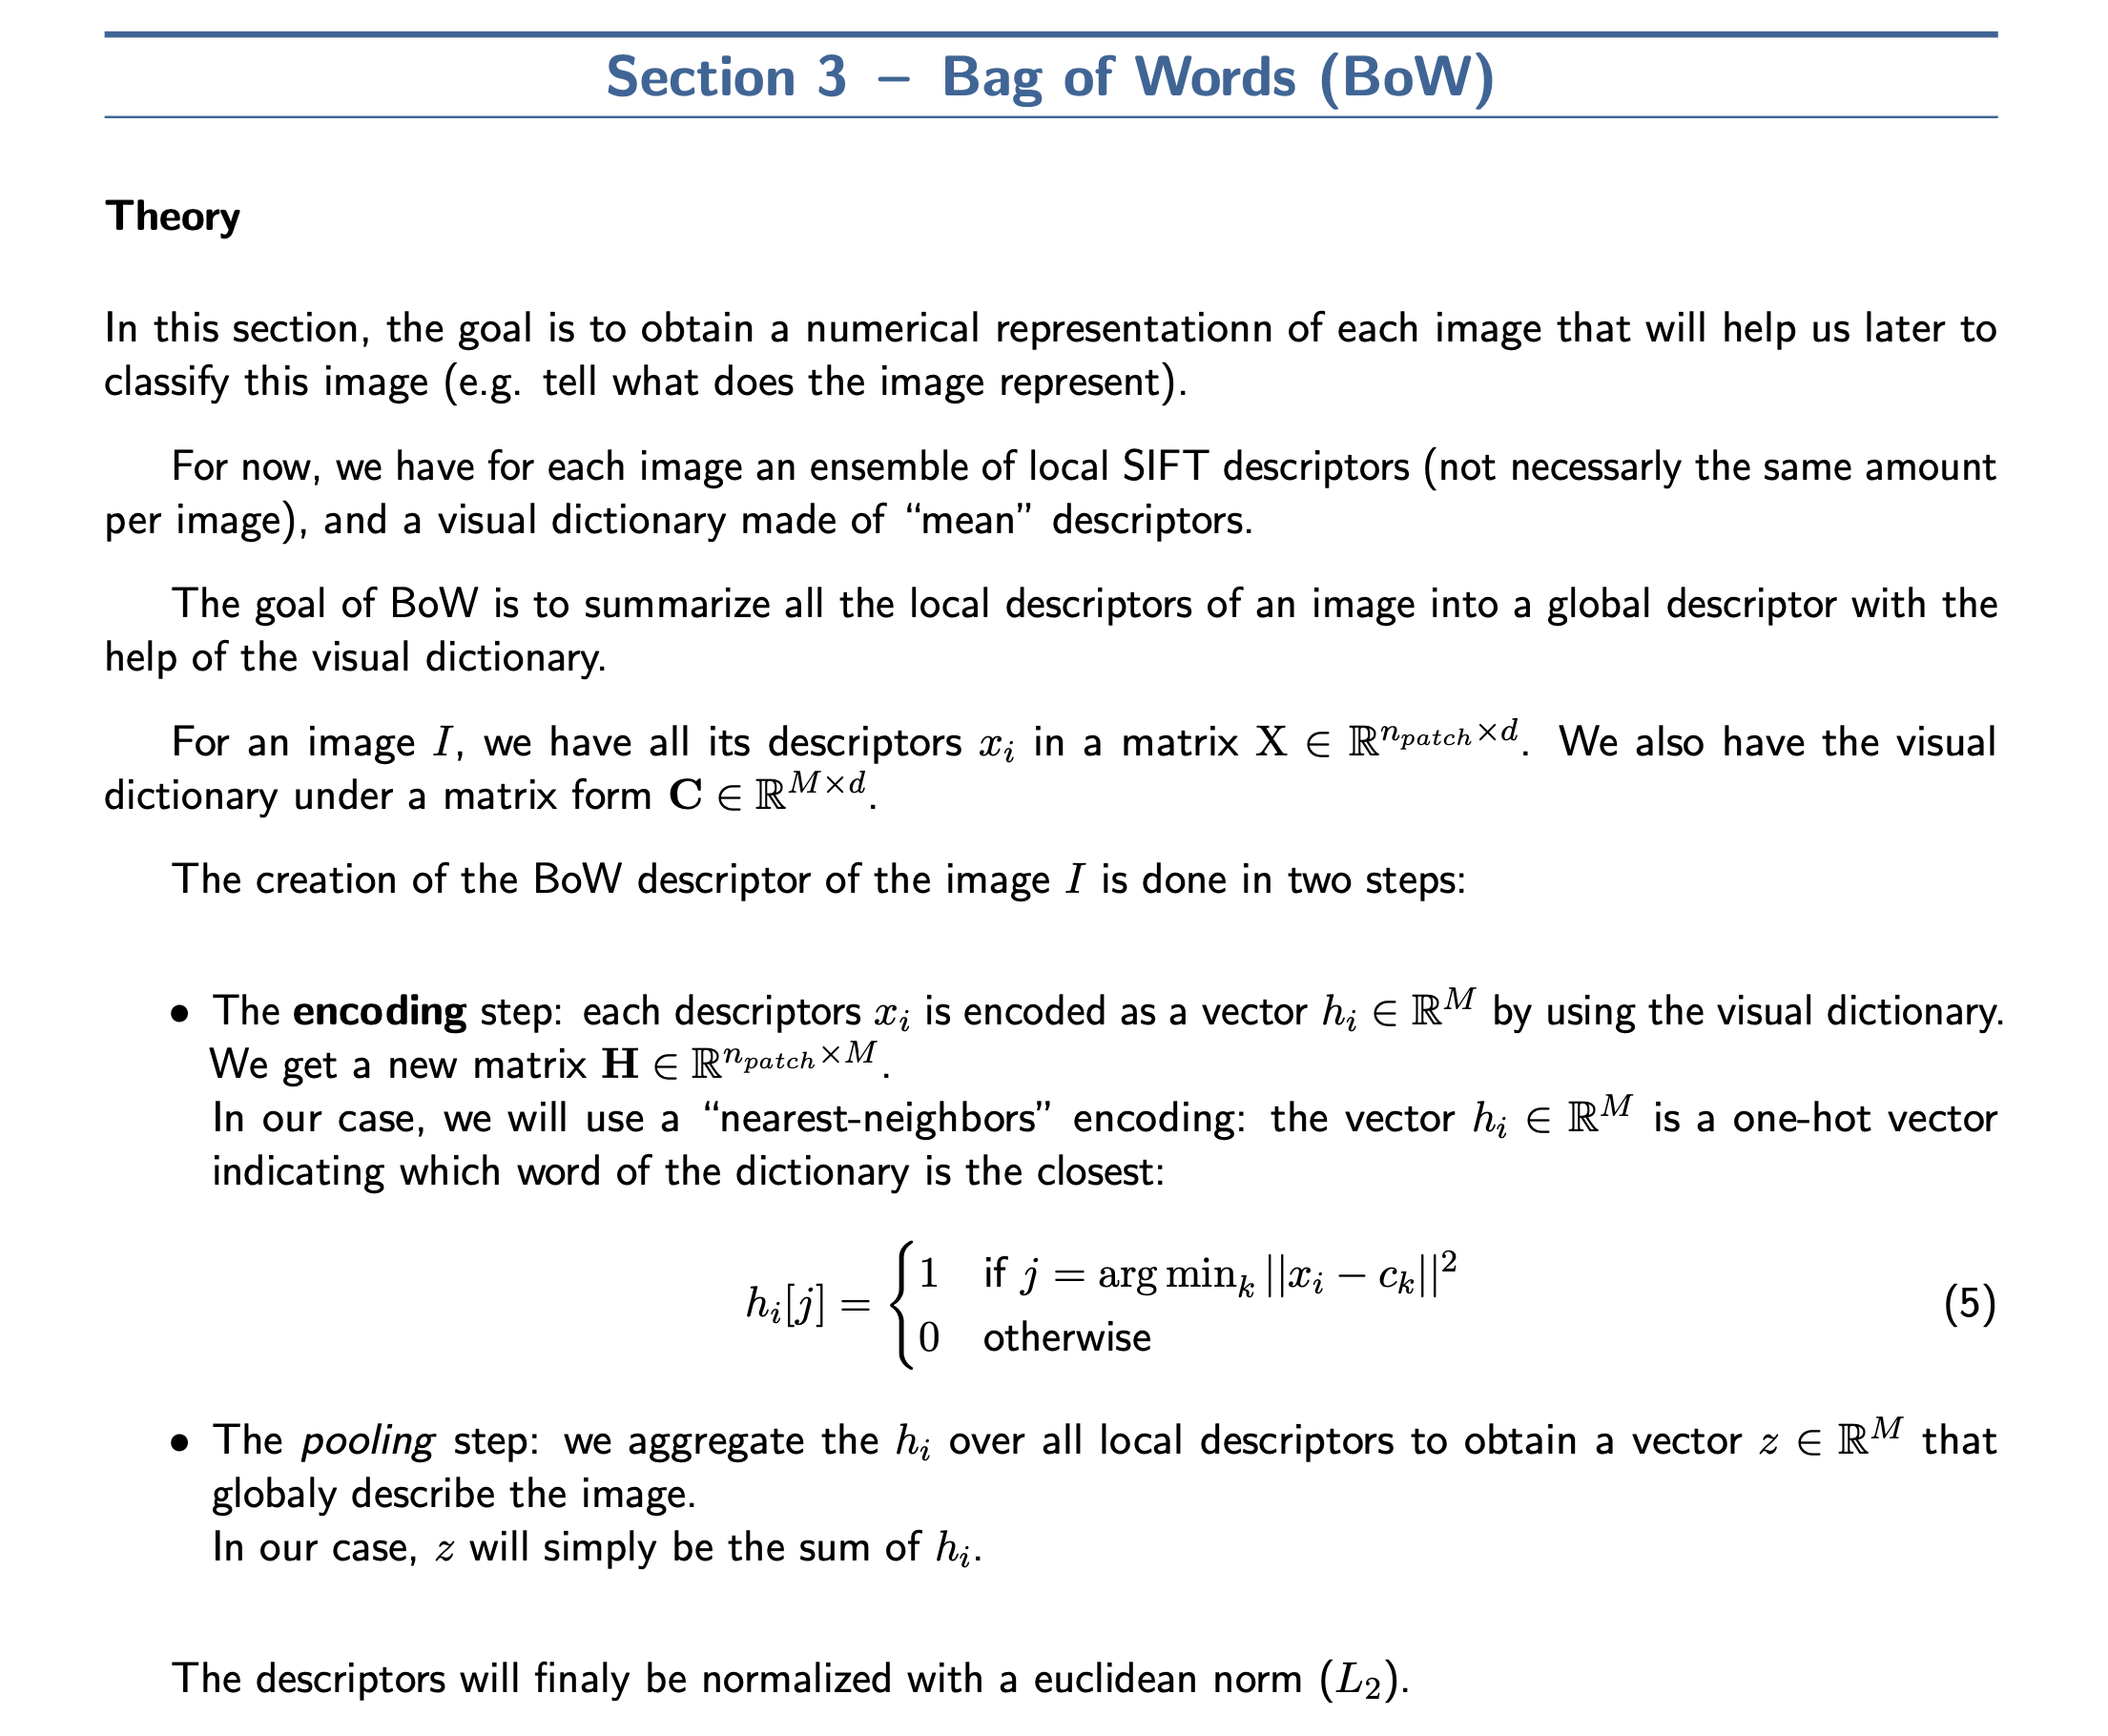

In [21]:
# TODO Compute BoW for an image
# indication: scipy.spatial.distance_matrix
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix

def compute_feats(vdict, image_sifts):
    """
    vdict: (num_clusters, 128): visual dictionnary containing all clusters.
    image_sifts: (H, W, 128) all sift features from the given image
    """
    # flatten sifts
    sifts = image_sifts.reshape(-1, 128)  # (N, 128)
    feats = np.zeros(vdict.shape[0])
    print(sifts.shape[0], feats.shape[0])

    # compute distance from image sifts to vdict
    dist = euclidean_distances(vdict, sifts)
    print(dist.shape)
    descriptor = (dist == dist.min(axis=0)[None,:]).astype(int).sum(axis=1)
    #print(descriptor.shape)
    #print(descriptor)

    #print(descriptor)

    return descriptor

1176 1001
(1001, 1176)


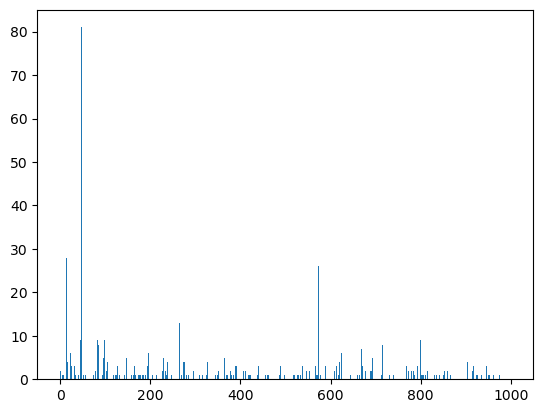

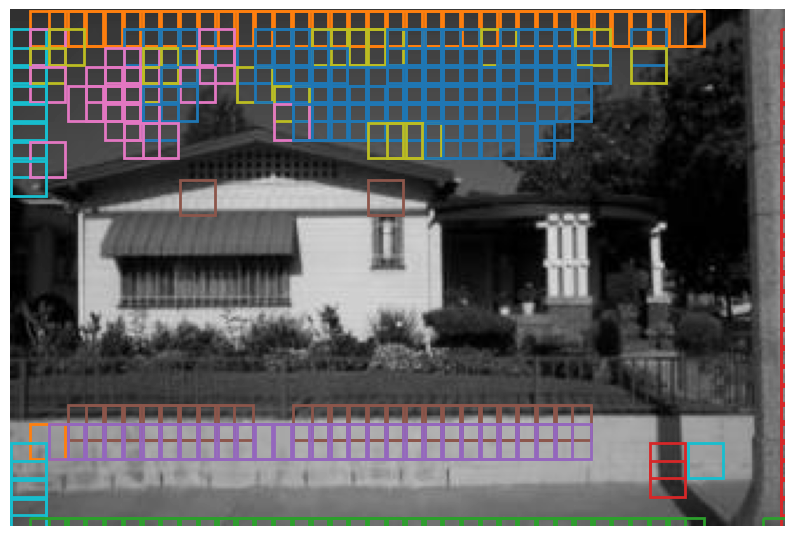

(9, 16, 16)


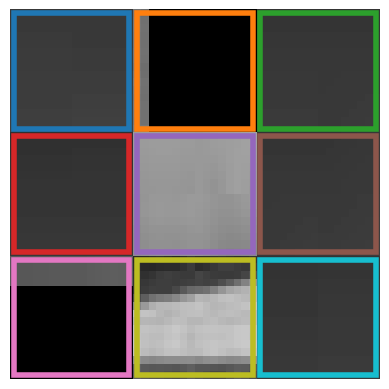

In [22]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
sift = (sift * 255).astype('uint8')
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here

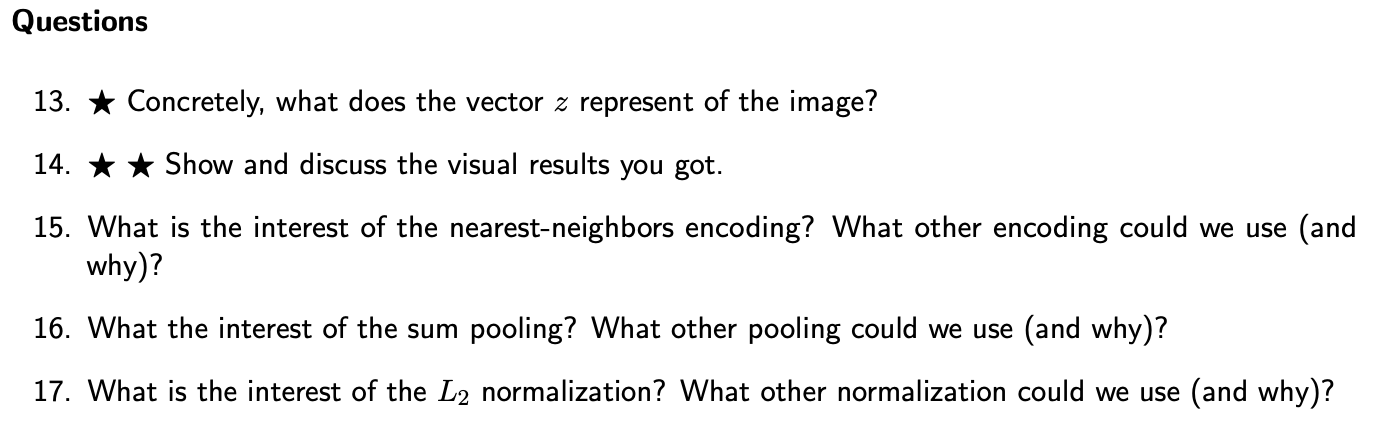

# Part IV: SVM

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

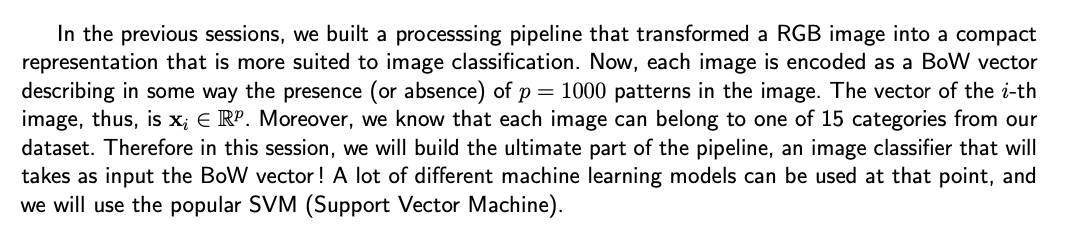

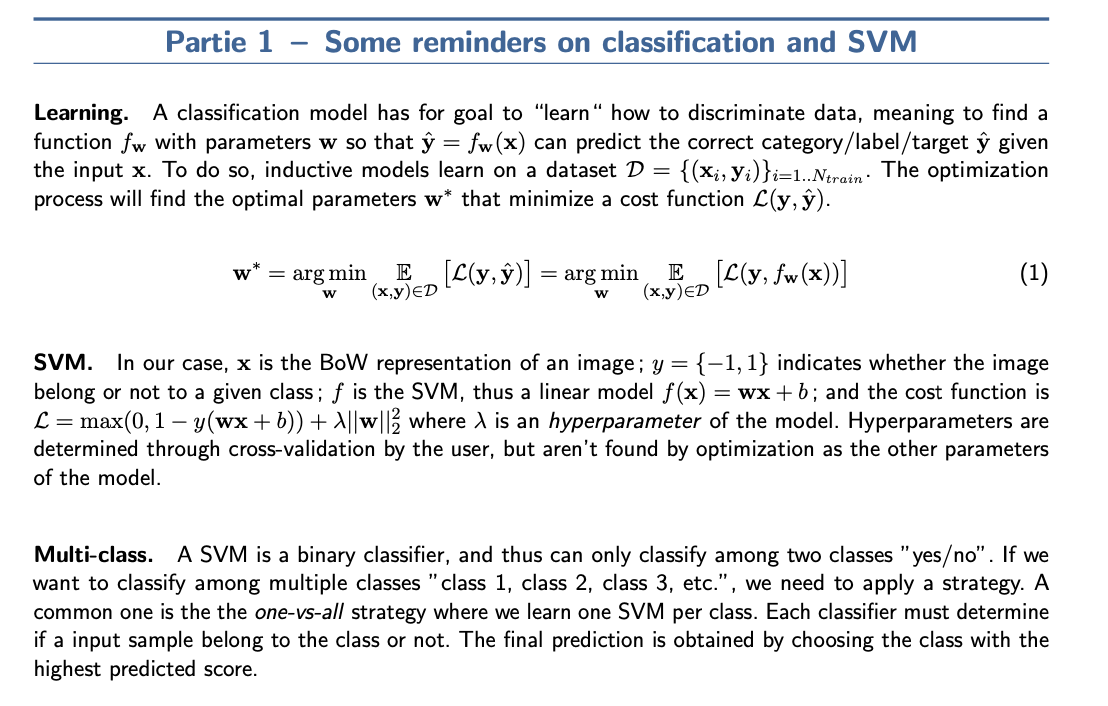

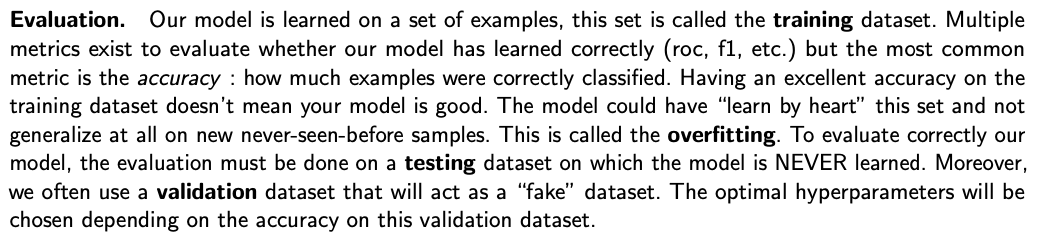

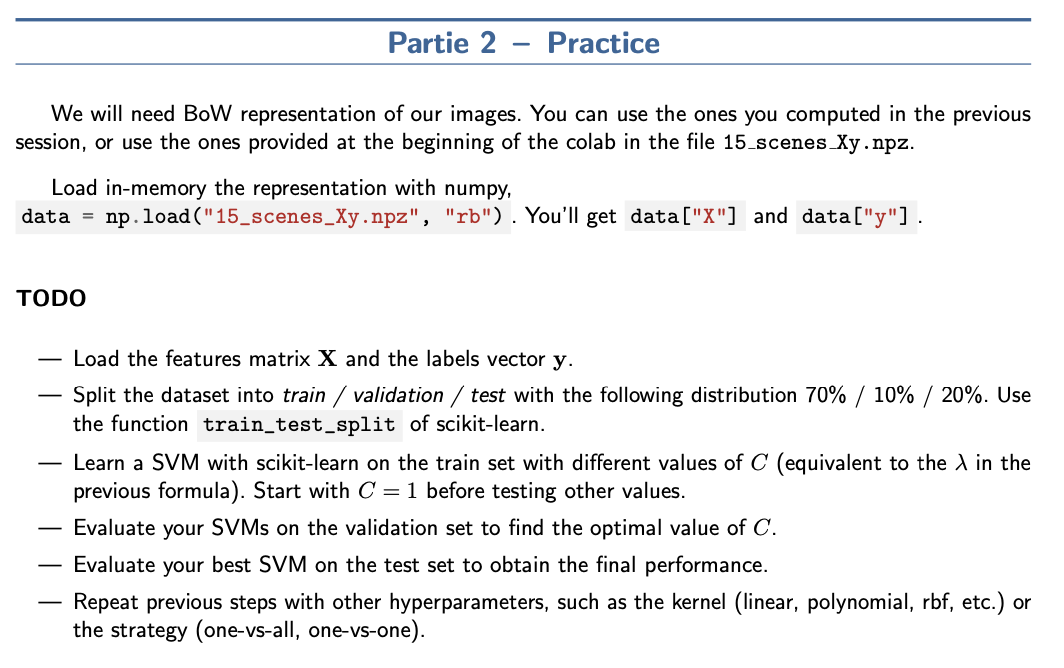

In [ ]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/15_scenes_Xy.npz

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split

Loading BoW of the whole dataset (4485 images, thus 4485 dictionnary of 1001 words):

In [24]:
data = np.load("data/15_scenes_Xy.npz")
X = data["X"]
y = data["y"]

X.shape, y.shape

((4485, 1001), (4485,))

In [27]:
min(y)

0

Let's see what is the class distribution:

In [28]:
{c: nb for c, nb in enumerate(np.bincount(y))}

{0: 241,
 1: 360,
 2: 328,
 3: 260,
 4: 308,
 5: 374,
 6: 410,
 7: 292,
 8: 356,
 9: 215,
 10: 216,
 11: 311,
 12: 210,
 13: 289,
 14: 315}

Split the dataset into a train & test set:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Then a validation set from the train set:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

Let's KFold over different values of `C`:

In [ ]:
C_values = [#TODO]
accuracies = []

for c in C_values:
  print(f'Training SVM with C={c}')
  #TODO

  # Fit on sub-train set
  # TODO

  # Evaluate on val set
  # TODO

  print(f'--> accuracy = {acc}')

In [ ]:
#TODO plot the relation between `c` and the accuracy

In [ ]:
#TODO Fit on the whole train set, evaluate on the test set

Do the same with different kernel values, and different decision functions:

In [ ]:
# TODO

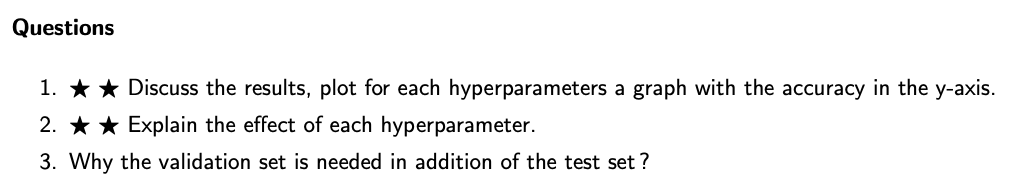